 # Google Thesios Data Analysis

## Overview  
Data analysis on google thesios data released on 27 April 2024.  
Know more about the Thesios from https://github.com/google-research-datasets/thesios

----------------------------------------------------------------------------------
**Total clusters**: 3  
**Trace duration**: 60 days  

## Data Categories  
**IO Zone**: WARM, COLD, UNKNOWN  
**Operation Type**: READ, WRITE  
**Service Class (Request Priority)**: LATENCY_SENSITIVE, THROUGHPUT_ORIENTED, OTHER  
**Flash Cache**: From flash cache: 0 or 1  
**Cache Hit**: Hit[1], Miss[0], Write[-1 or n/a]  


## Traces Analysis

#### Install dependencies

In [1]:
!pip3 install pandas
!pip3 install pandas matplotlib
!pip3 install google-cloud-storage
!pip3 install pyarrow
!pip3 install anytree
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### Import dependencies

In [2]:
from google.cloud import storage
import os
import random
import requests
import pandas as pd
import concurrent.futures
from collections import defaultdict
import math
from anytree import Node, RenderTree
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


#### In this section, helper methods such as download data from GCS and load to dataframe etc are defined

In [3]:
def list_bucket_contents(bucket_name, prefix=""):
    """Lists all blobs in the bucket with the given prefix."""
    storage_client = storage.Client.create_anonymous_client()
    return list(storage_client.list_blobs(bucket_name, prefix=prefix))

def group_by_immediate_subfolder(blobs, parent_folder):
    """Groups blobs by the immediate subfolder within the specified parent folder."""
    subfolders = defaultdict(list)
    parent_prefix = parent_folder.rstrip('/') + '/'
    for blob in blobs:
        if blob.name.startswith(parent_prefix):
            relative_path = blob.name[len(parent_prefix):]
            subfolder = relative_path.split('/')[0]
            if '/' in relative_path: 
                subfolders[subfolder].append(blob)
    return subfolders

def download_file(url, destination_path):
    """Downloads a file from a given URL."""
    response = requests.get(url)
    if response.status_code == 200:
        with open(destination_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {url} to {destination_path}")
        return destination_path
    else:
        print(f"Failed to download {url}")
        return None

def random_download_files(bucket_name, parent_folder, num_files=3):
    """Randomly downloads a specified number of files from each the subfolder of the parent folder."""
    blobs = list_bucket_contents(bucket_name, parent_folder)
    subfolders = group_by_immediate_subfolder(blobs, parent_folder)
    
    base_url = f"https://storage.googleapis.com/{bucket_name}/"
    current_dir = os.getcwd()
    download_dir = os.path.join(current_dir, "downloaded_files")
    os.makedirs(download_dir, exist_ok=True)
    
    downloaded_files = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        future_to_url = {}
        for subfolder, subfolder_blobs in subfolders.items():
            selected_blobs = random.sample(subfolder_blobs, min(num_files, len(subfolder_blobs)))
            for blob in selected_blobs:
                url = base_url + blob.name
                new_filename = f"{subfolder}-{os.path.basename(blob.name)}"
                destination_path = os.path.join(download_dir, new_filename)
                future = executor.submit(download_file, url, destination_path)
                future_to_url[future] = (url, destination_path)
        
        for future in concurrent.futures.as_completed(future_to_url):
            url, destination_path = future_to_url[future]
            try:
                downloaded_path = future.result()
                if downloaded_path:
                    downloaded_files.append(downloaded_path)
            except Exception as exc:
                print(f"{url} generated an exception: {exc}")
    
    return downloaded_files

def load_files_to_dataframe(file_paths):
    """Loads multiple CSV files into a single DataFrame"""
    dataframes = []
    columns_to_drop = ['filename', 'file_offset', 'application', 'c_time', 'start_time'] #, 'simulated_disk_start_time']
    
    for file_path in file_paths:
        # Read only the columns we want to keep
        df = pd.read_csv(file_path, usecols=lambda x: x not in columns_to_drop)
        dataframes.append(df)
        os.remove(file_path)
    
    return pd.concat(dataframes, ignore_index=True)

def convert_size(size_bytes):
    """
    Convert size in bytes to KB or MB for improved readability, rounding down to the nearest integer.
    """
    if isinstance(size_bytes, str):
        return size_bytes
    
    kb = 1024
    mb = kb * 1024
    
    if size_bytes < kb:
        return f"{size_bytes} B"
    elif size_bytes < mb:
        return f"{size_bytes // kb} KB"
    else:
        return f"{size_bytes // mb} MB"


# Function to analyze and print distribution
def analyze_distribution(column, name):
    counts = thesios_df[column].value_counts()
    total = len(thesios_df)
    print(f"\n{name} Distribution:")
    for value, count in counts.items():
        percentage = (count / total) * 100
        print(f"{value}: {count} ({percentage:.2f}%)")

# Function to analyze I/O sizes
def analyze_io_size(column, name):
    sizes = thesios_df[column]
    print(f"\n{name} Analysis:")
    
    print(f"Distinct sizes: {sizes.nunique()}")
    print(f"Lowest size: {sizes.min()} bytes ({convert_size(sizes.min())})")
    print(f"Highest size: {sizes.max()} bytes ({convert_size(sizes.max())})")
    
def analyze_request_sizes(df):
    grouped = df.groupby(['request_io_size_bucket', 'cache_hit', 'from_flash_cache'])
    
    size_breakdown = grouped.size().reset_index(name='count')
    
    pivot_table = size_breakdown.pivot_table(
        index=['request_io_size_bucket'], 
        columns=['cache_hit', 'from_flash_cache'], 
        values='count', 
        fill_value=0
    )
    
    # Add total count column
    pivot_table['Total'] = pivot_table.sum(axis=1)
    
    return pivot_table


def request_size_distribution_by_op_type(df):
    size_order = ['0B', '512B', '4KB', '64KB', '512KB', '1MB', '8MB']
    
    grouped = df.groupby(['op_type', 'request_io_size_bucket'])
    
    results = {}
    for op_type, op_group in df.groupby('op_type'):
        distribution = {}
        total_count = len(op_group)
        
        for bucket in size_order:
            bucket_group = grouped.get_group((op_type, bucket)) if (op_type, bucket) in grouped.groups else pd.DataFrame()
            bucket_count = len(bucket_group)
            
            if bucket_count > 0:
                latency_stats = bucket_group['simulated_latency'].agg(['mean', 'median', 'std'])
                distribution[bucket] = {
                    'count': bucket_count,
                    'percentage': (bucket_count / total_count) * 100,
                    'simulated_latency': {
                        'mean': latency_stats['mean'],
                        'median': latency_stats['median'],
                        'std': latency_stats['std']
                    }
                }
        
        results[op_type] = {
            'distribution': distribution,
            'total_count': total_count
        }
    
    # Calculate overall percentages
    total_ops = sum(data['total_count'] for data in results.values())
    for op_type, data in results.items():
        data['overall_percentage'] = (data['total_count'] / total_ops) * 100
    
    return results

def plot_trend(title, storage_dfs, field, message):
    plt.figure(figsize=(14, 7))
    sizes = ['512B', '4KB', '64KB', '512KB', '1MB']
    x = np.arange(len(sizes))
    colors = ['#2ecc71', '#e67e22', '#e74c3c', '#3498db']
    labels = ['NVMe', 'SSD', 'HDD', 'Thesios']
    
    # Width of a bar 
    width = 0.2
    
    for i, (df, label, color) in enumerate(zip(storage_dfs, labels, colors)):
        latencies = [df[df['request_io_size_bucket'].str.contains(size, case=False, na=False)][field].mean()*1000 for size in sizes]
        
        # Offset each storage type's bars
        offset = width * i
        bars = plt.bar(x + offset, latencies, width, label=label, color=color)
        
        # Calculate and annotate ratios
        base_latency = latencies[0]  # 512B as base
        for i in range(0,len(sizes)):
            plt.text(x[i] + offset, latencies[i], f'{latencies[i]/base_latency:.2f}x', 
                 color='black', ha='center', va='bottom')

    plt.title(title, pad=20, fontsize=14)
    plt.ylabel(message, fontsize=12)
    plt.xlabel('IO Size', fontsize=12)
    plt.xticks(x + width * 1.5, sizes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

def get_size_bandwidth(df, bucket_field='request_io_size_bucket', bandwidth_field='bandwidth'):
    # Define the sizes we want to analyze
    sizes = ['512B', '4KB', '64KB', '512KB', '1MB']
    results = {}
    for size in sizes:
        mask = df[bucket_field].str.contains(size, case=False, na=False)
        if mask.any():
            results[size] = df[mask][bandwidth_field].mean()
        else:
            results[size] = np.nan
            
    return results

def size_distribution_graph(df_writes, df_reads):
    # Calculate value counts for writes
    write_counts = df_writes['request_io_size_bucket'].value_counts(normalize=True) * 100
    write_counts = write_counts.reindex(custom_order, fill_value=0)

    # Calculate value counts for reads
    read_counts = df_reads['request_io_size_bucket'].value_counts(normalize=True) * 100
    read_counts = read_counts.reindex(custom_order, fill_value=0) 

    # Prepare the bar chart
    x = range(len(custom_order))  
    width = 0.4 

    plt.figure(figsize=(10, 6))

    # Bar for writes
    plt.bar([pos - width/2 for pos in x], write_counts, width=width, color='skyblue', edgecolor='black', alpha=0.8, label='Writes')

    # Bar for reads
    plt.bar([pos + width/2 for pos in x], read_counts, width=width, color='lightcoral', edgecolor='black', alpha=0.8, label='Reads')

    plt.title('Request IO Size Distribution: Writes vs Reads')
    plt.xlabel('Request IO Size Buckets')
    plt.ylabel('Percentage (%)')
    plt.xticks(ticks=x, labels=custom_order, rotation=45)
    plt.yticks()

    for index, value in enumerate(write_counts):
        plt.text(index - width/2, value + 0.5, f'{value:.1f}%', ha='center')
    for index, value in enumerate(read_counts):
        plt.text(index + width/2, value + 0.5, f'{value:.1f}%', ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()



### Load dataframe

In [4]:
# For the given parent folder(here cluster1_16TB), it first checks if the csv file is already downloaded to the disk and if available,
# load the file into dataframe directly. If the CSV file is not present, then the traces are downloaded from the google cloud storage. 
# Each day's traces are in its respective day folder of the format YYYYMMDD. From each day, we select 10 files. We process each file to fetch 
# Drop fields such as filename, file offset, application, c time, start time and simulated disk start time from the dataframe as they 
# are not necessary in this analysis.

if __name__ == "__main__":
   
    # Get the present working directory
    pwd = os.getcwd()
    
    # Check if 'thesios_data.csv' exists in the PWD
    file_name = "thesios_data.csv"
    file_path = os.path.join(pwd, file_name)
    
    if os.path.isfile(file_path):
        print(f"'{file_name}' exists in the current directory.")
        columns_to_drop = ['filename', 'file_offset', 'application', 'c_time', 'start_time', 'simulated_disk_start_time']
        thesios_df = pd.read_csv(file_path, usecols=lambda x: x not in columns_to_drop)
    else:
        print(f"'{file_name}' not found in the current directory.")
        bucket_name = "thesios-io-traces"
        parent_folder = "cluster1_16TB/"  # The parent folder
        files_per_subfolder = 10

         # Download files
        downloaded_files = random_download_files(bucket_name, parent_folder, files_per_subfolder)

        thesios_df = load_files_to_dataframe(downloaded_files)
        # Save the combined DataFrame to a CSV file
        thesios_df.to_csv("thesios_data.csv", index=False)

        print(f"Downloaded and loaded {len(downloaded_files)} files into a DataFrame.")


'thesios_data.csv' exists in the current directory.


### Thesios dataframe information

In [5]:
thesios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90845430 entries, 0 to 90845429
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   io_zone                 object 
 1   redundancy_type         object 
 2   op_type                 object 
 3   service_class           object 
 4   from_flash_cache        int64  
 5   cache_hit               int64  
 6   request_io_size_bytes   int64  
 7   disk_io_size_bytes      int64  
 8   response_io_size_bytes  int64  
 9   disk_time               float64
 10  simulated_latency       float64
dtypes: float64(2), int64(5), object(4)
memory usage: 7.4+ GB


## Data spread by each attribute

In [6]:
analyze_distribution('io_zone', 'IO Zone')
analyze_distribution('op_type', 'Operation Type')
analyze_distribution('service_class', 'Service Class')
analyze_distribution('from_flash_cache', 'From Flash Cache')
analyze_distribution('cache_hit', 'Cache Hit')

analyze_io_size('request_io_size_bytes', 'Request I/O Size')
analyze_io_size('response_io_size_bytes', 'Response I/O Size')
analyze_io_size('disk_io_size_bytes', 'Disk I/O Size')


IO Zone Distribution:
WARM: 87928724 (96.79%)
COLD: 2894480 (3.19%)
UNKNOWN: 22226 (0.02%)

Operation Type Distribution:
WRITE: 52235293 (57.50%)
READ: 38610137 (42.50%)

Service Class Distribution:
THROUGHPUT_ORIENTED: 63902909 (70.34%)
LATENCY_SENSITIVE: 23893216 (26.30%)
OTHER: 3049305 (3.36%)

From Flash Cache Distribution:
0: 84302559 (92.80%)
1: 6542871 (7.20%)

Cache Hit Distribution:
-1: 52235293 (57.50%)
0: 23104278 (25.43%)
1: 15505859 (17.07%)

Request I/O Size Analysis:
Distinct sizes: 1040613
Lowest size: 0 bytes (0 B)
Highest size: 9455616 bytes (9 MB)

Response I/O Size Analysis:
Distinct sizes: 216100
Lowest size: 0 bytes (0 B)
Highest size: 9455616 bytes (9 MB)

Disk I/O Size Analysis:
Distinct sizes: 1013734
Lowest size: 0 bytes (0 B)
Highest size: 9465856 bytes (9 MB)


### Measure bandwidth in mbps from response_io_size_bytes and disk_time

In [7]:
# Create bandwidth column 
thesios_df['bandwidth'] = -1  # Set all to -1 as invalid.

# Calculate bandwidth when disk_time > 0 and response_io_size_bytes > 0
valid_mask = (thesios_df['disk_time'] > 0) & (thesios_df['response_io_size_bytes'] > 0)
thesios_df.loc[valid_mask, 'bandwidth'] = (thesios_df.loc[valid_mask, 'response_io_size_bytes'] / (1024 * 1024)) / thesios_df.loc[valid_mask, 'disk_time']

/tmp/ipykernel_944641/2241785945.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.80346141 10.04840986  2.79319294 ... 94.70420188 35.90081329
 56.40830223]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  thesios_df.loc[valid_mask, 'bandwidth'] = (thesios_df.loc[valid_mask, 'response_io_size_bytes'] / (1024 * 1024)) / thesios_df.loc[valid_mask, 'disk_time']


### The sizes in request_io_size_bytes are represented in bytes, with 1040613 different sizes in our dataset. For simplicity and our understanding, let's group them to the nearest of the following sizes. 
[0 B, 512 B, 4KB, 64 KB, 512 KB, 1 MB, 8 MB]

In [8]:
# Define the bucket sizes in bytes
BUCKET_SIZES = {
    '0B': 0,
    '512B': 512,
    '4KB': 4 * 1024,
    '64KB': 64 * 1024,
    '512KB': 512 * 1024,
    '1MB': 1024 * 1024,
    '8MB': 8 * 1024 * 1024
}

def map_to_nearest_bucket(size):
    bucket_values = list(BUCKET_SIZES.values())
    nearest_value = min(bucket_values, key=lambda x: abs(x - size))
    return next(name for name, value in BUCKET_SIZES.items() if value == nearest_value)

thesios_df['request_io_size_bucket'] = thesios_df['request_io_size_bytes'].apply(map_to_nearest_bucket)

## Lets look at sample data from dataframe, including the bandwidth and the request IO buckets.

In [9]:
thesios_df.head()

,io_zone,redundancy_type,op_type,service_class,from_flash_cache,cache_hit,request_io_size_bytes,disk_io_size_bytes,response_io_size_bytes,disk_time,simulated_latency,bandwidth,request_io_size_bucket
0,WARM,ERASURE_CODED,READ,THROUGHPUT_ORIENTED,0,0,43008,45056,43008,0.022743,0.022743,1.803461,64KB
1,WARM,ERASURE_CODED,READ,THROUGHPUT_ORIENTED,0,0,81920,266240,81920,0.007775,0.026994,10.048410,64KB
2,WARM,ERASURE_CODED,READ,THROUGHPUT_ORIENTED,0,0,43008,45056,43008,0.014684,0.040544,2.793193,64KB
3,WARM,ERASURE_CODED,READ,THROUGHPUT_ORIENTED,0,0,282624,258048,282624,0.003174,0.024423,84.915990,64KB
4,WARM,ERASURE_CODED,READ,THROUGHPUT_ORIENTED,1,1,262144,0,262144,0.000000,0.000099,-1.000000,64KB


### Note that there are requests with IO size of 0 bytes. 

In [10]:
df_zero_kb = thesios_df[thesios_df['request_io_size_bytes'] == 0]

In [11]:
for attribute in df_zero_kb.columns:
    print("Field: {} ".format(attribute))
    print("Unique values: {}".format(df_zero_kb[attribute].unique()))
    print("Length: {}".format(len(df_zero_kb[attribute].unique())),"\n")

Field: io_zone 
Unique values: ['WARM' 'COLD' 'UNKNOWN']
Length: 3 

Field: redundancy_type 
Unique values: ['REPLICATED' 'ERASURE_CODED']
Length: 2 

Field: op_type 
Unique values: ['WRITE']
Length: 1 

Field: service_class 
Unique values: ['THROUGHPUT_ORIENTED' 'OTHER' 'LATENCY_SENSITIVE']
Length: 3 

Field: from_flash_cache 
Unique values: [0 1]
Length: 2 

Field: cache_hit 
Unique values: [-1]
Length: 1 

Field: request_io_size_bytes 
Unique values: [0]
Length: 1 

Field: disk_io_size_bytes 
Unique values: [0]
Length: 1 

Field: response_io_size_bytes 
Unique values: [0]
Length: 1 

Field: disk_time 
Unique values: [0.]
Length: 1 

Field: simulated_latency 
Unique values: [1.0755200e-04 7.6615000e-05 5.1801000e-05 ... 4.0315200e-04 1.2967298e-02
 2.2167969e-02]
Length: 355039 

Field: bandwidth 
Unique values: [-1.]
Length: 1 

Field: request_io_size_bucket 
Unique values: ['0B']
Length: 1 



### Surprisingly, 0 bytes requests are only on WRITE service type. We assume this could be metadata update trace. Lets see what percentage of overall data has 0 byte requests

In [12]:
# Calculating the percentage of records in thesios_df that whose request IO is 0 bytes.
zero_kb_count = df_zero_kb.shape[0]
thesios_df_count = thesios_df.shape[0]

percentage_zero_kb = (zero_kb_count / thesios_df_count) * 100

print(f"Percentage of df_zero_kb in thesios_df: {percentage_zero_kb:.2f}%")


Percentage of df_zero_kb in thesios_df: 15.54%


### Analyse requests spread

#### Lets analyse by grouping based on service_class (LATENCY_SENSITIVE/THROUGHPUT_ORIENTED). 

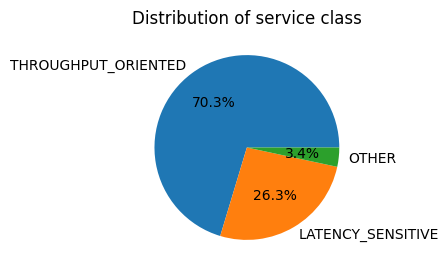

In [13]:
plt.figure(figsize=(3, 3))
thesios_df['service_class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of service class')
plt.ylabel('')
plt.show()

#### Let's analyse READ/WRITE distribution for each service_class

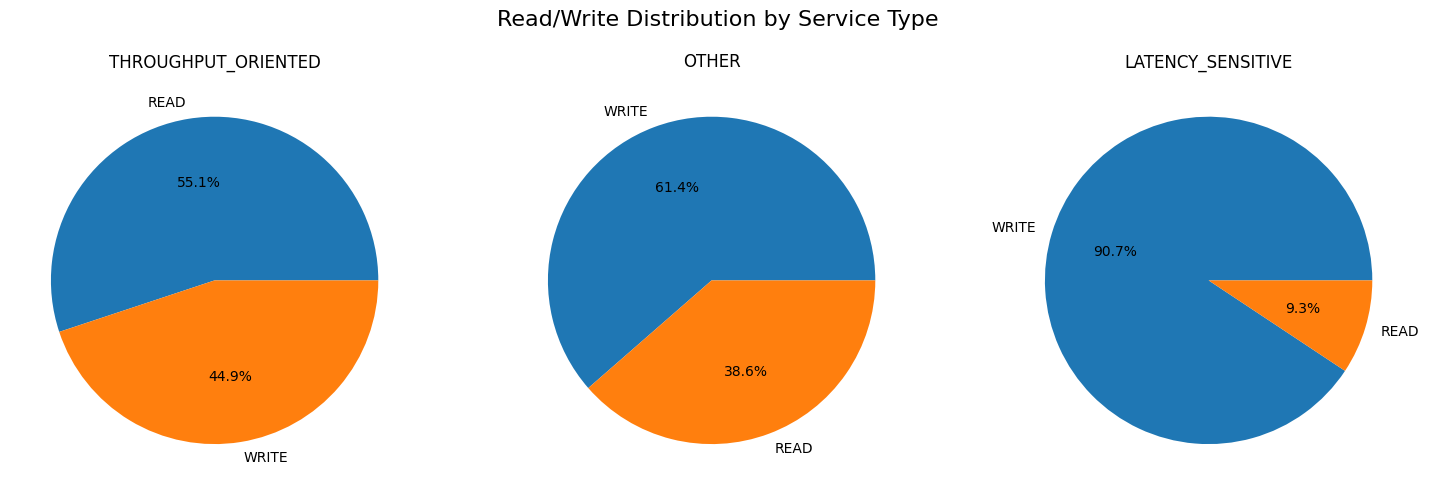

In [14]:
service_types = thesios_df['service_class'].unique()

fig, axes = plt.subplots(1, len(service_types), figsize=(15, 5))

for i, service_type in enumerate(service_types):
    service_df = thesios_df[thesios_df['service_class'] == service_type]
    
    service_df['op_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[i])
    
    axes[i].set_title(service_type)
    axes[i].set_ylabel('')

fig.suptitle('Read/Write Distribution by Service Type', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

#### Lets analyse by grouping based on op_type[READ/WRITE]. 

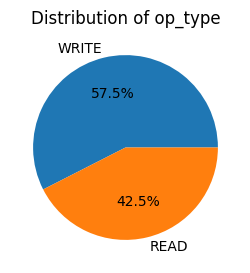

In [15]:
plt.figure(figsize=(3, 3))
thesios_df['op_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of op_type')
plt.ylabel('')
plt.show()

In [16]:
# Filter for write operations for each disk type
thesios_writes = thesios_df[(thesios_df['op_type'] == "WRITE")]

# Filter for read operations for each disk type
thesios_reads = thesios_df[(thesios_df['op_type'] == "READ")]

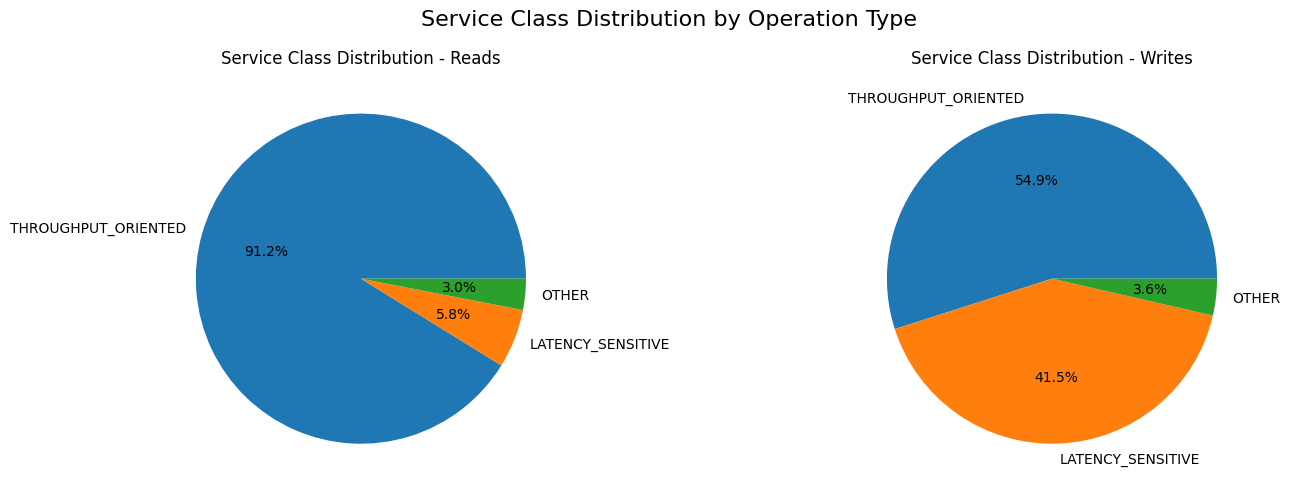

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

service_class_reads = thesios_reads['service_class'].value_counts()
ax1.pie(service_class_reads, labels=service_class_reads.index, autopct='%1.1f%%')
ax1.set_title('Service Class Distribution - Reads')

service_class_writes = thesios_writes['service_class'].value_counts()
ax2.pie(service_class_writes, labels=service_class_writes.index, autopct='%1.1f%%')
ax2.set_title('Service Class Distribution - Writes')

fig.suptitle('Service Class Distribution by Operation Type', fontsize=16)

plt.tight_layout()
plt.show()

#### Let's see the request size distribution grouped by op_type[read/write]

In [18]:
distribution = request_size_distribution_by_op_type(thesios_df)

for op_type, data in distribution.items():
    print(f"\nOperation Type: {op_type}")
    print(f"Total Count: {data['total_count']} ({data['overall_percentage']:.2f}%)")
    print("------------------------")
    for bucket, stats in data['distribution'].items():
        print(f"{bucket}: {stats['count']} ({stats['percentage']:.2f}%)")


Operation Type: READ
Total Count: 38610137 (42.50%)
------------------------
0B: 183696 (0.48%)
512B: 155508 (0.40%)
4KB: 4050975 (10.49%)
64KB: 22554081 (58.41%)
512KB: 4232739 (10.96%)
1MB: 7222107 (18.71%)
8MB: 211031 (0.55%)

Operation Type: WRITE
Total Count: 52235293 (57.50%)
------------------------
0B: 15165117 (29.03%)
512B: 7082492 (13.56%)
4KB: 12687247 (24.29%)
64KB: 6774538 (12.97%)
512KB: 2077068 (3.98%)
1MB: 8448831 (16.17%)


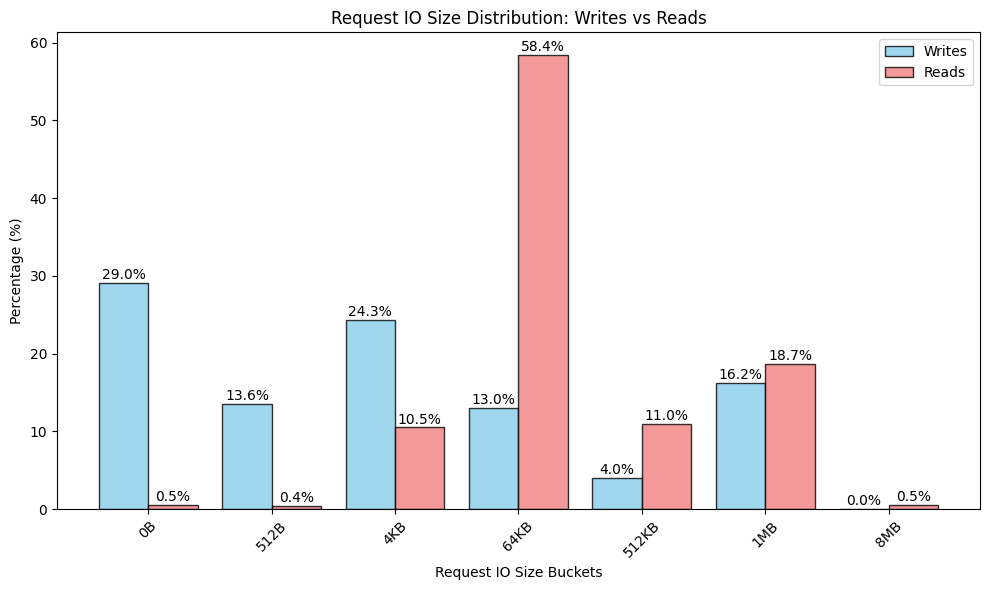

In [19]:
custom_order = ['0B', '512B', '4KB', '64KB', '512KB', '1MB', '8MB']
size_distribution_graph(thesios_writes, thesios_reads)


#### Let's see the write request distribution by cache_hit and flash cache values. 

In [21]:
result = analyze_request_sizes(thesios_writes)
print("Write trace cache, flash cache spread")
print(result)

Write trace cache, flash cache spread
cache_hit                       -1                Total
from_flash_cache                 0        1            
request_io_size_bucket                                 
0B                      15165111.0      6.0  15165117.0
1MB                      8448826.0      5.0   8448831.0
4KB                     12670655.0  16592.0  12687247.0
512B                     7082492.0      0.0   7082492.0
512KB                    2077067.0      1.0   2077068.0
64KB                     6774538.0      0.0   6774538.0


#### Cache hit value for writes is always -1. All writes are fulfilled using the server’s writeback buffer cache.
Note: Flash cache is SSD in thesios. Cache represents server’s buffer cache 

#### Let's analyse if we can draw any observations by correlation

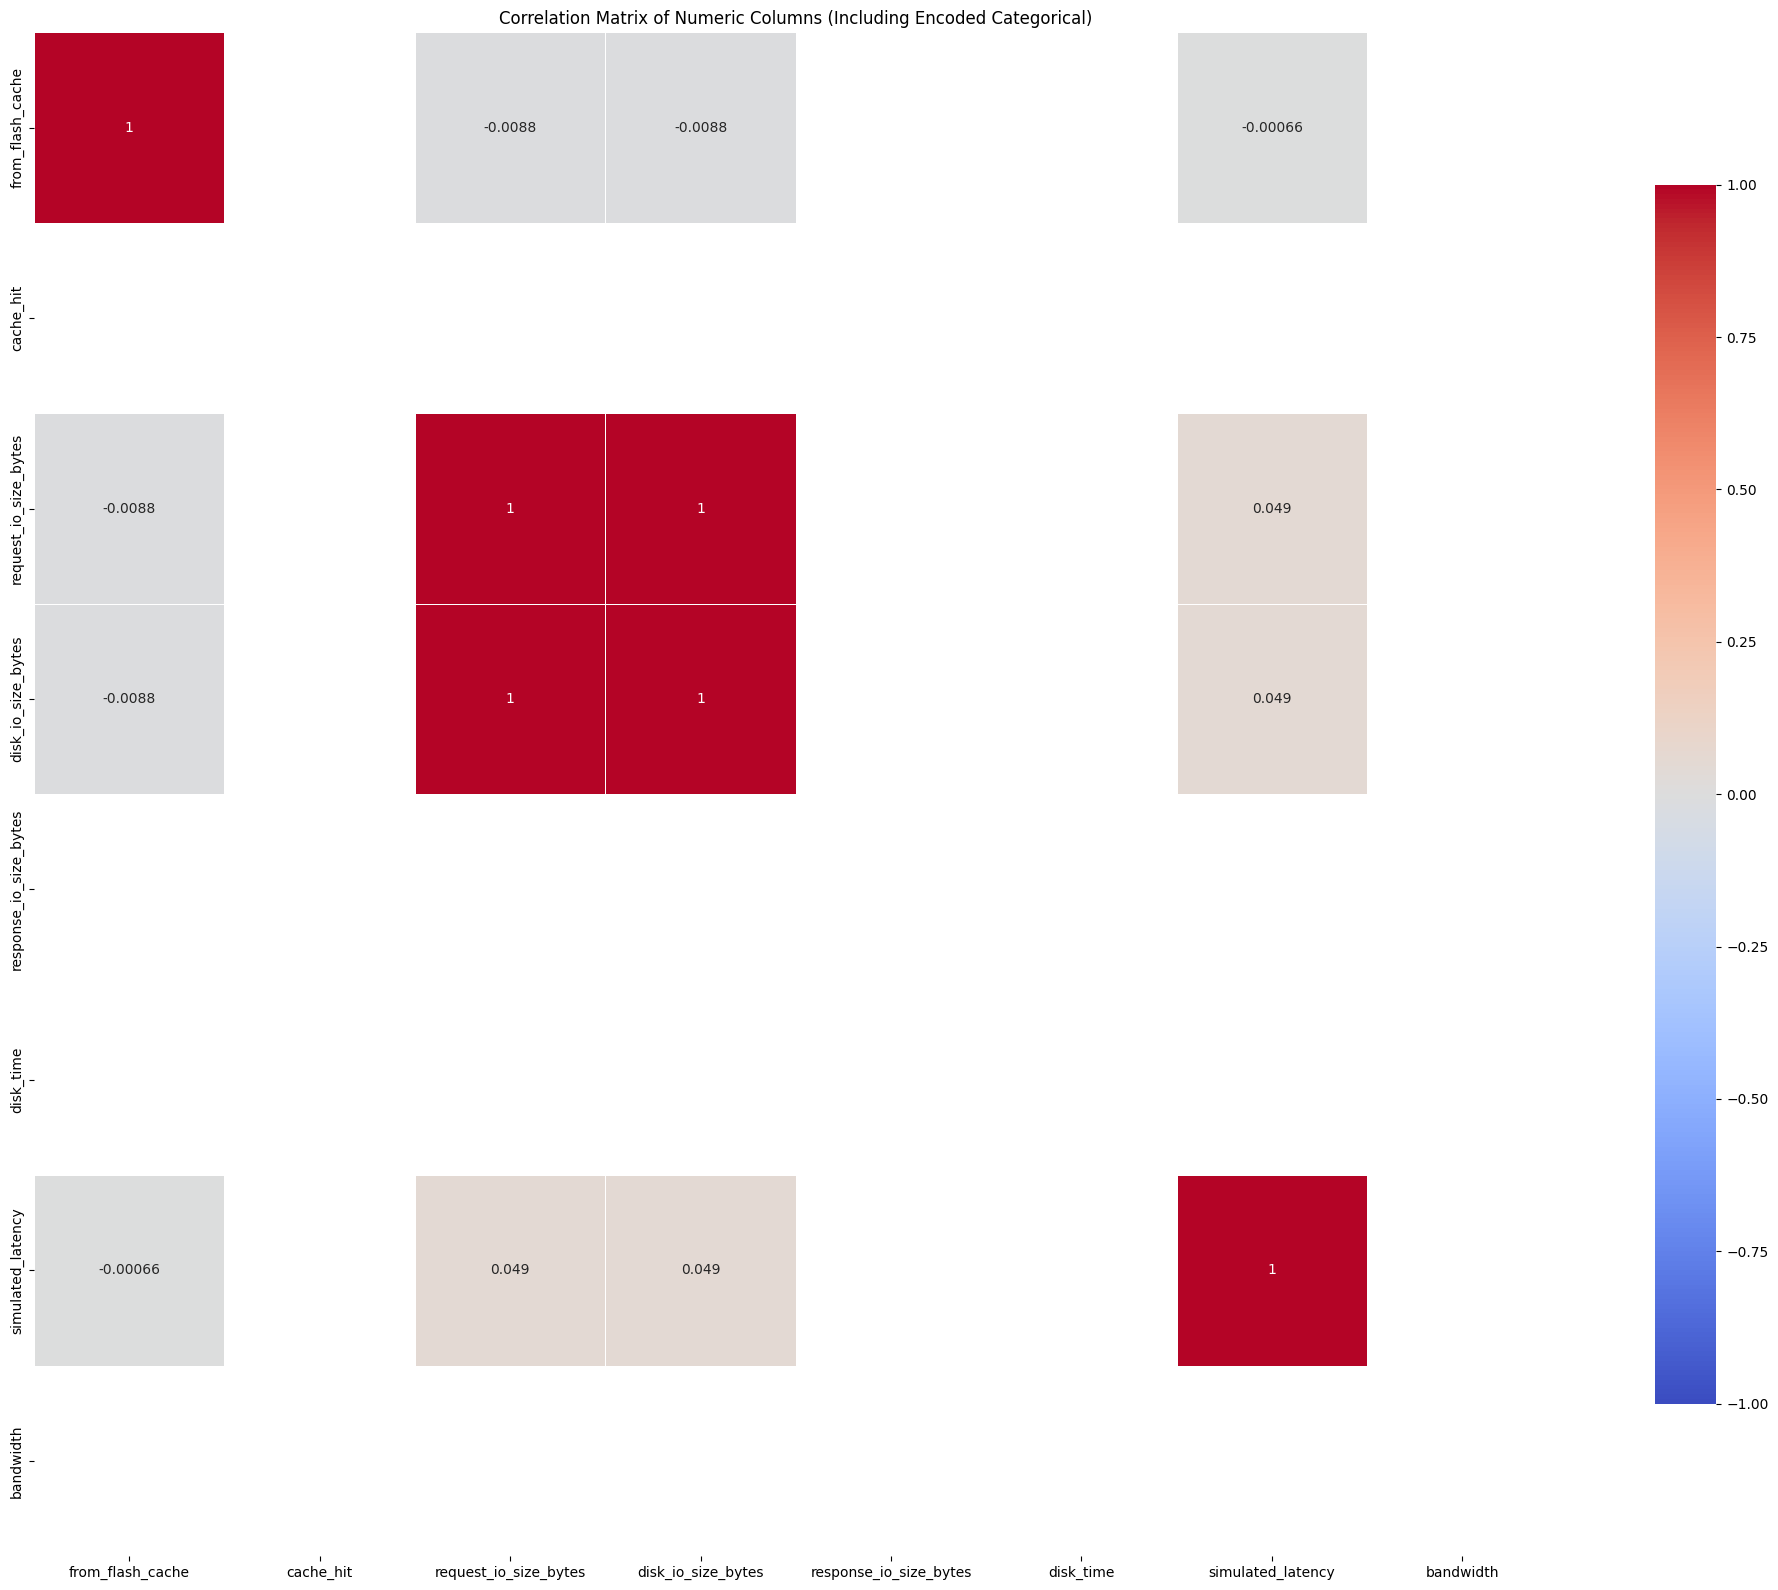

In [22]:
numeric_df = thesios_writes.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize correlation
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, 
            annot=True,      # Show numerical values
            cmap='coolwarm', # Color palette
            center=0,        # Center color at 0
            vmin=-1,         # Minimum correlation value
            vmax=1,          # Maximum correlation value
            square=True,     # Make the plot square
            linewidths=0.5,  # Add lines between cells
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Columns (Including Encoded Categorical)')
plt.tight_layout()
plt.show()


#### This correlation has no much info because cache_hit is always -1 for wirtes. response_io, disk time and bandwidth are 0 and the request IO and disk_io_size_bytes are always the same.

#### Let's see the read request traces distribution by cache_hit values. 

In [23]:
result = analyze_request_sizes(thesios_reads)
print("Read trace cache, flash cache spread")
print(result)

Read trace cache, flash cache spread
cache_hit                        0                   1                  Total
from_flash_cache                 0        1          0          1            
request_io_size_bucket                                                       
0B                          6842.0      0.0   176770.0       84.0    183696.0
1MB                      5497331.0      0.0  1724776.0        0.0   7222107.0
4KB                      2485476.0    297.0  1506208.0    58994.0   4050975.0
512B                       12901.0      0.0   137592.0     5015.0    155508.0
512KB                    3228533.0      0.0  1004206.0        0.0   4232739.0
64KB                    11760210.0  17494.0  4331994.0  6444383.0  22554081.0
8MB                        95194.0      0.0   115837.0        0.0    211031.0


#### Read requests for each file size category has both cache hit and non cache hit requests. A few requests are from the flash cache.
#### The below graph represents the cache hit and non cache hit distribution 

<Figure size 1200x600 with 0 Axes>

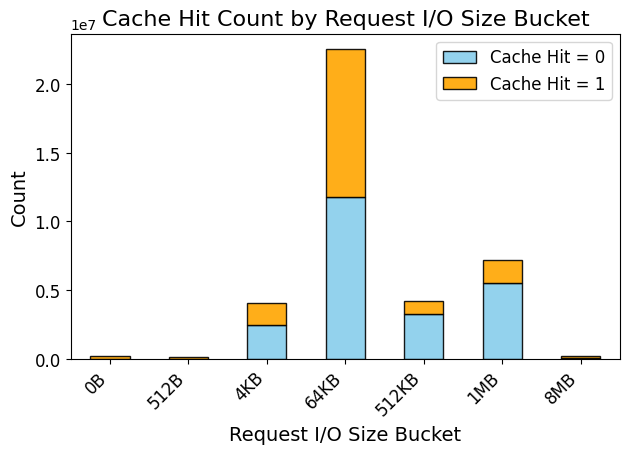

In [24]:
# Group the data by request_io_size_bucket and cache_hit
cache_hit_counts = thesios_reads.groupby(['request_io_size_bucket', 'cache_hit']).size().unstack(fill_value=0)

cache_hit_counts = cache_hit_counts.reindex(custom_order, fill_value=0)

plt.figure(figsize=(12, 6))
cache_hit_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], edgecolor='black', alpha=0.9)

plt.xlabel('Request I/O Size Bucket', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Cache Hit Count by Request I/O Size Bucket', fontsize=16)
plt.legend(['Cache Hit = 0', 'Cache Hit = 1'], fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

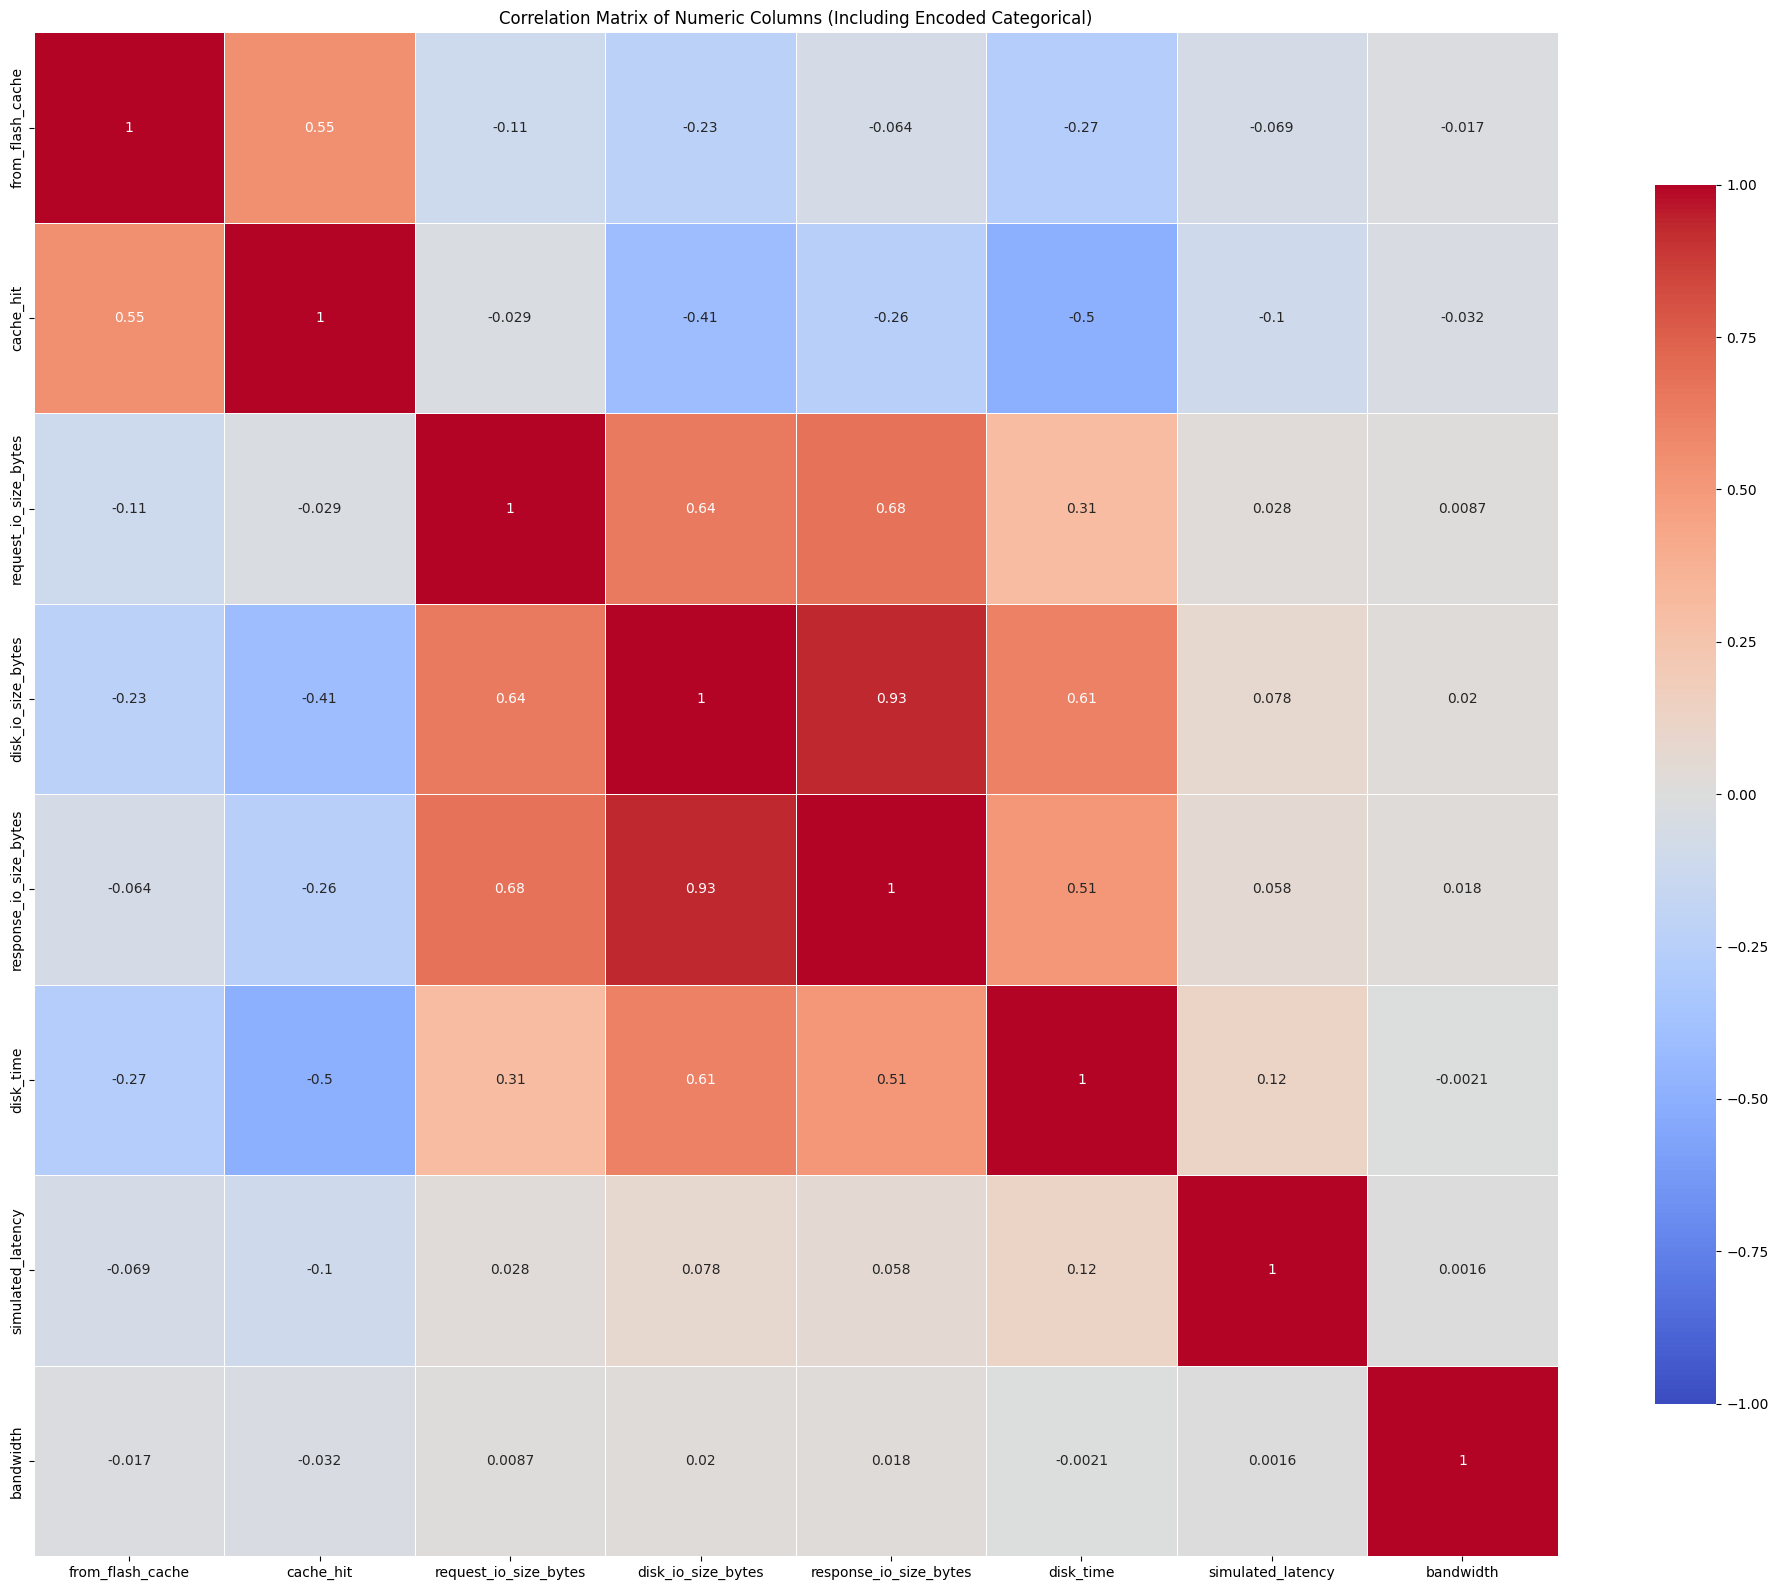

In [25]:
numeric_df = thesios_reads.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize correlation
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, 
            annot=True,     
            cmap='coolwarm',
            center=0,       
            vmin=-1,        
            vmax=1,         
            square=True,  
            linewidths=0.5,  
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Columns (Including Encoded Categorical)')
plt.tight_layout()
plt.show()


#### For read operations, we can see that there os good correlation between 

#### Bandwidth Analysis for the read operations

In [26]:
def bandwidth_distribution_by_op_type(df):
    
    grouped = df.groupby(['op_type', 'request_io_size_bucket'])
    
    results = {}
    for op_type, op_group in df.groupby('op_type'):
        distribution = {}
        total_count = len(op_group)
        
        for bucket in custom_order:
            bucket_group = grouped.get_group((op_type, bucket)) if (op_type, bucket) in grouped.groups else pd.DataFrame()
            bucket_count = len(bucket_group)
            
            if bucket_count > 0:
                valid_bandwidth = bucket_group[bucket_group['bandwidth'] != -1]['bandwidth']
                invalid_count = bucket_count - len(valid_bandwidth)
                
                if len(valid_bandwidth) > 0:
                    bandwidth_stats = valid_bandwidth.agg(['min', 'mean', 'max'])
                else:
                    bandwidth_stats = {'min': None, 'mean': None, 'max': None}
                
                distribution[bucket] = {
                    'count': bucket_count,
                    'percentage': (bucket_count / total_count) * 100,
                    'bandwidth': {
                        'min': bandwidth_stats['min'],
                        'mean': bandwidth_stats['mean'],
                        'max': bandwidth_stats['max'],
                        'invalid_count': invalid_count 
                    }
                }
        
        results[op_type] = {
            'distribution': distribution,
            'total_count': total_count
        }
    
    total_ops = sum(data['total_count'] for data in results.values())
    for op_type, data in results.items():
        data['overall_percentage'] = (data['total_count'] / total_ops) * 100
    
    return results


In [29]:
distribution = bandwidth_distribution_by_op_type(thesios_reads)

for op_type, data in distribution.items():
    print(f"Operation Type: {op_type}")
    print(f"Total Count: {data['total_count']} ({data['overall_percentage']:.2f}%)")
    print("------------------------")
    for bucket, stats in data['distribution'].items():
        print(f"{bucket}: {stats['count']} ({stats['percentage']:.2f}%)")
        print(f"  Bandwidth - Min: {stats['bandwidth']['min']}, Mean: {stats['bandwidth']['mean']}, Max: {stats['bandwidth']['max']}")


Operation Type: READ
Total Count: 38610137 (100.00%)
------------------------
0B: 183696 (0.48%)
  Bandwidth - Min: 6.831766646342861e-05, Mean: 0.01076666244601197, Max: 2.00076090228768
512B: 155508 (0.40%)
  Bandwidth - Min: 0.0041907039446568446, Mean: 0.3062519761836309, Max: 39.61405717897878
4KB: 4050975 (10.49%)
  Bandwidth - Min: 0.005912521236719304, Mean: 17.810396654889143, Max: 24091.409691629957
64KB: 22554081 (58.41%)
  Bandwidth - Min: 0.03250675380890297, Mean: 91.0653760870299, Max: 1098632.8125
512KB: 4232739 (10.96%)
  Bandwidth - Min: 0.11078452143961862, Mean: 127.17614143811187, Max: 257158.82532509952
1MB: 7222107 (18.71%)
  Bandwidth - Min: 0.5359452095751894, Mean: 129.60986001834172, Max: 8196721.311475409
8MB: 211031 (0.55%)
  Bandwidth - Min: 11.182726400484539, Mean: 148.11271133801569, Max: 7476.659530425906


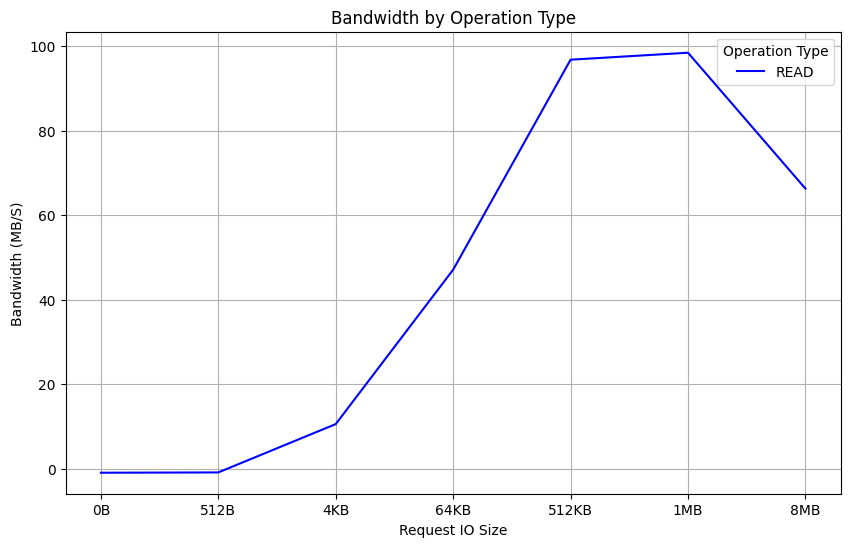

In [28]:
grouped_data = thesios_reads.groupby(['op_type', 'request_io_size_bucket'])['bandwidth'].mean().reset_index()
color_mapping = {'READ': 'blue', 'WRITE': 'orange'}
bandwidth_pivot = grouped_data.pivot(index='request_io_size_bucket', columns='op_type', values='bandwidth')
plt.figure(figsize=(10, 6))
bandwidth_pivot = bandwidth_pivot.reindex(custom_order)

for op_type in bandwidth_pivot.columns:
    sns.lineplot(
        x=bandwidth_pivot.index,
        y=bandwidth_pivot[op_type],
        label=op_type,
        color=color_mapping[op_type]
    )

plt.title('Bandwidth by Operation Type')
plt.xlabel('Request IO Size')
plt.ylabel('Bandwidth (MB/S)')
plt.legend(title='Operation Type')
plt.grid(True)
plt.show()


### Latency Analysis

In [30]:
def detailed_latency_analysis(df):
        
    # Group by op_type and request_io_size_bucket
    grouped = df.groupby(['op_type', 'request_io_size_bucket'])
    
    results = {}
    for op_type, op_group in df.groupby('op_type'):
        distribution = {}
        total_count = len(op_group)
        
        for bucket in custom_order:
            bucket_group = grouped.get_group((op_type, bucket)) if (op_type, bucket) in grouped.groups else pd.DataFrame()
            bucket_count = len(bucket_group)
            
            if bucket_count > 0:
                min_size_row = bucket_group.loc[bucket_group['request_io_size_bytes'].idxmin()]
                max_size_row = bucket_group.loc[bucket_group['request_io_size_bytes'].idxmax()]
                
                distribution[bucket] = {
                    'count': bucket_count,
                    'percentage': (bucket_count / total_count) * 100,
                    'min_size': {
                        'bytes': min_size_row['request_io_size_bytes'],
                        'latency': min_size_row['simulated_latency']
                    },
                    'max_size': {
                        'bytes': max_size_row['request_io_size_bytes'],
                        'latency': max_size_row['simulated_latency']
                    },
                    'latency_variance': bucket_group['simulated_latency'].var()
                }
        
        results[op_type] = {
            'distribution': distribution,
            'total_count': total_count
        }
    
    total_ops = sum(data['total_count'] for data in results.values())
    for op_type, data in results.items():
        data['overall_percentage'] = (data['total_count'] / total_ops) * 100
    
    return results

In [31]:
distribution = detailed_latency_analysis(thesios_df)

for op_type, data in distribution.items():
    print(f"\nOperation Type: {op_type}")
    print(f"Total Count: {data['total_count']} ({data['overall_percentage']:.2f}%)")
    print("------------------------")
    for bucket, stats in data['distribution'].items():
        print(f"{bucket}: {stats['count']} ({stats['percentage']:.2f}%)")
        print(f"  \t Smallest request: {stats['min_size']['bytes']} bytes;  Latency: {stats['min_size']['latency']:.6f}")
        print(f"  \t Largest request: {stats['max_size']['bytes']} bytes;  Latency: {stats['max_size']['latency']:.6f}")
        print(f"  Latency Variance: {stats['latency_variance']:.6f}")

grand_total = sum(data['total_count'] for data in distribution.values())
print(f"\nGrand Total: {grand_total}")


Operation Type: READ
Total Count: 38610137 (42.50%)
------------------------
0B: 183696 (0.48%)
  	 Smallest request: 2 bytes;  Latency: 0.047814
  	 Largest request: 256 bytes;  Latency: 0.000078
  Latency Variance: 0.000061
512B: 155508 (0.40%)
  	 Smallest request: 257 bytes;  Latency: 0.000047
  	 Largest request: 2304 bytes;  Latency: 0.000050
  Latency Variance: 0.000398
4KB: 4050975 (10.49%)
  	 Smallest request: 2305 bytes;  Latency: 0.000062
  	 Largest request: 34816 bytes;  Latency: 0.000122
  Latency Variance: 0.027500
64KB: 22554081 (58.41%)
  	 Smallest request: 34817 bytes;  Latency: 0.000072
  	 Largest request: 294912 bytes;  Latency: 0.039515
  Latency Variance: 0.003986
512KB: 4232739 (10.96%)
  	 Smallest request: 294913 bytes;  Latency: 0.054684
  	 Largest request: 786432 bytes;  Latency: 0.003422
  Latency Variance: 0.001751
1MB: 7222107 (18.71%)
  	 Smallest request: 786433 bytes;  Latency: 0.010446
  	 Largest request: 4718335 bytes;  Latency: 0.000104
  Laten

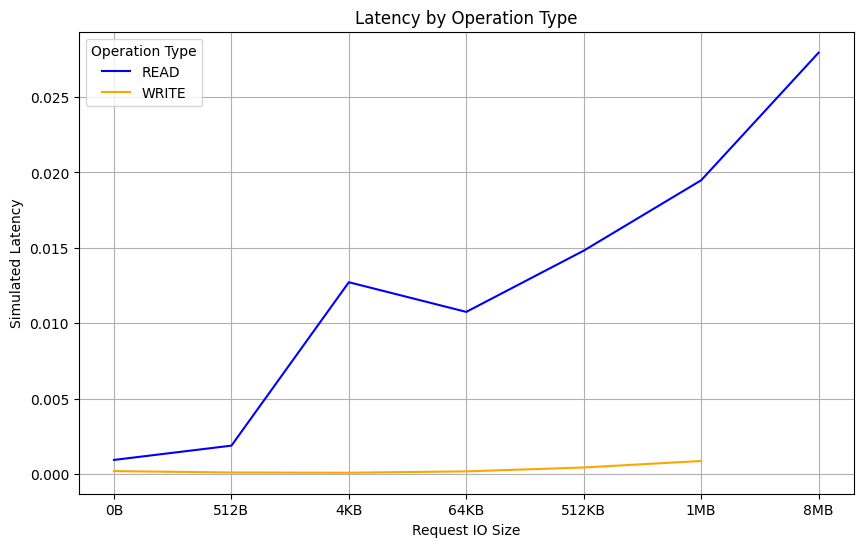

In [32]:
grouped_data = thesios_df.groupby(['op_type', 'request_io_size_bucket'])['simulated_latency'].mean().reset_index()

pivot_data = grouped_data.pivot(index='request_io_size_bucket', columns='op_type', values='simulated_latency')

pivot_data = pivot_data.reindex(custom_order)

plt.figure(figsize=(10, 6))

for op_type in pivot_data.columns:
    sns.lineplot(
        x=pivot_data.index,
        y=pivot_data[op_type],
        label=op_type,
        color=color_mapping[op_type]
    )

# Set the title, labels, and legend
plt.title('Latency by Operation Type')
plt.xlabel('Request IO Size')
plt.ylabel('Simulated Latency')
plt.legend(title='Operation Type')
plt.grid(True)
plt.show()

# Analysis ARES

In [33]:
csv_paths = [
            # '~/vpb/experiment/darshan_parser/darshan_summary_nvme.csv', 
            # '~/vpb/experiment/darshan_parser/darshan_summary_22_hdd_20241123_120132.csv',
            # '~/vpb/experiment/darshan_parser/darshan_summary_23_hdd_20241123_163327.csv',
            # '~/vpb/experiment/darshan_parser/darshan_summary_23_hdd_20241123_201703.csv',
            # '~/vpb/experiment/darshan_parser/darshan_summary_23_hdd_20241123_234022.csv',
            '~/vpb/experiment/darshan_parser/darshan_summary_23_hdd_20241124_001315.csv',# - segment is 1
            '~/vpb/experiment/darshan_parser/darshan_summary_24_hdd_20241124_003309.csv',
            '~/vpb/experiment/darshan_parser/darshan_summary_24_all_20241124_103103.csv',
            '~/vpb/experiment/darshan_parser/darshan_summary_24_all_20241124_140857.csv',
             '~/vpb/experiment/darshan_parser/darshan_summary_24_all_20241124_173911.csv',
            '~/vpb/experiment/darshan_parser/darshan_summary_24_all_20241124_205840.csv',
            '~/vpb/experiment/darshan_parser/darshan_summary_24_all_20241125_084106.csv',
            '~/vpb/experiment/darshan_parser/darshan_summary_25_all_20241125_084622.csv'
            ]

ares_df = pd.concat(
            [pd.read_csv(path) for path in csv_paths],
            ignore_index=True)
ares_df = ares_df.drop_duplicates()
ares_df = ares_df[ares_df['response_io'] != 8 * 1024 * 1024]

In [34]:
ares_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086833 entries, 0 to 1299521
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   record_id    1086833 non-null  uint64 
 1   filename     1086833 non-null  object 
 2   disk_type    1086833 non-null  object 
 3   op_type      1086833 non-null  object 
 4   response_io  1086833 non-null  int64  
 5   start_time   1086833 non-null  float64
 6   end_time     1086833 non-null  float64
 7   disk_time    1086833 non-null  float64
dtypes: float64(3), int64(1), object(3), uint64(1)
memory usage: 74.6+ MB


In [35]:
# List all columns except filename
columns_to_analyze = ['record_id', 'disk_type', 'op_type', 'response_io']

# Get unique values for each column
for column in columns_to_analyze:
    print(f"\n{column} unique values:")
    print(ares_df[column].unique())
    print(f"Total unique values: {ares_df[column].nunique()}")
    


record_id unique values:
[ 4686797191328531615 11682850930464615396  5085883852029329973 ...
  7513573267336265025 14457122530775529979   125232635712151390]
Total unique values: 99201

disk_type unique values:
['hdd' 'ssd' 'nvme']
Total unique values: 3

op_type unique values:
['write' 'read']
Total unique values: 2

response_io unique values:
[  65536 1048576    4096  524288     512]
Total unique values: 5


In [36]:
#Add Latency
ares_df['latency'] = ares_df['end_time'] - ares_df['start_time']

In [37]:
#add bandwidth
# Calculate bandwidth only for read operations (in MB/s)
ares_df['bandwidth'] = 0.0  # Initialize bandwidth column with zeros
mask = ares_df['op_type'] == 'read'
ares_df.loc[mask, 'bandwidth'] = ares_df.loc[mask, 'response_io'] / (1024 * 1024) / ares_df.loc[mask, 'disk_time']


In [38]:
ares_df['request_io_size_bucket'] = ares_df['response_io'].apply(map_to_nearest_bucket)

In [39]:
ares_df.head()

,record_id,filename,disk_type,op_type,response_io,start_time,end_time,disk_time,latency,bandwidth,request_io_size_bucket
0,4686797191328531615,/mnt/hdd/vpapudesibabu/iortests/test-0-64kb-65...,hdd,write,65536,3.360367,3.360548,0.000181,0.000181,0.0,64KB
1,11682850930464615396,/mnt/hdd/vpapudesibabu/iortests/test-0-64kb-65...,hdd,write,65536,3.373010,3.373134,0.000124,0.000124,0.0,64KB
2,5085883852029329973,/mnt/hdd/vpapudesibabu/iortests/test-0-64kb-65...,hdd,write,65536,3.377924,3.378168,0.000243,0.000244,0.0,64KB
3,780455218714604171,/mnt/hdd/vpapudesibabu/iortests/test-0-64kb-65...,hdd,write,65536,3.334069,3.334205,0.000136,0.000136,0.0,64KB
4,3130476736552269236,/mnt/hdd/vpapudesibabu/iortests/test-0-64kb-65...,hdd,write,65536,3.396472,3.396605,0.000133,0.000133,0.0,64KB


In [40]:
# Ares Reads DF
ares_read_df = ares_df[ares_df['op_type'] == 'read']

# Ares Writes DF
ares_write_df = ares_df[ares_df['op_type'] == 'write']

# Ares nvme DF
ares_nvme_df = ares_df[ares_df['disk_type'] == 'nvme']

# Ares nvme Reads DF
ares_nvme_read_df = ares_nvme_df[ares_nvme_df['op_type'] == 'read']

# Ares nvme Writes DF
ares_nvme_write_df = ares_nvme_df[ares_nvme_df['op_type'] == 'write']

# Ares SSD DF
ares_ssd_df = ares_df[ares_df['disk_type'] == 'ssd']

# Ares SSD Reads DF
ares_ssd_read_df = ares_ssd_df[ares_ssd_df['op_type'] == 'read']

# Ares SSD Writes DF
ares_ssd_write_df = ares_ssd_df[ares_ssd_df['op_type'] == 'write']

# Ares HDD DF
ares_hdd_df = ares_df[ares_df['disk_type'] == 'hdd']

# Ares HDD Reads DF
ares_hdd_read_df = ares_hdd_df[ares_hdd_df['op_type'] == 'read']

# Ares HDD Writes DF
ares_hdd_write_df = ares_hdd_df[ares_hdd_df['op_type'] == 'write']


#### Traces captured from Ares cluster by disk: 

In [41]:
print(f"The total I/O traces captured from Ares cluster: {len(ares_df)}")
print(f"The total I/O traces captured from NVME: {len(ares_nvme_df)}")
print(f"The total I/O traces captured from SSD: {len(ares_ssd_df)}")
print(f"The total I/O traces captured from HDD: {len(ares_hdd_df)}")

The total I/O traces captured from Ares cluster: 1086833
The total I/O traces captured from NVME: 326207
The total I/O traces captured from SSD: 513971
The total I/O traces captured from HDD: 246655


Total number of read operations: 609522
Total number of write operations: 477311

Number of unique files (reads): 99073
Number of unique files (writes): 99201


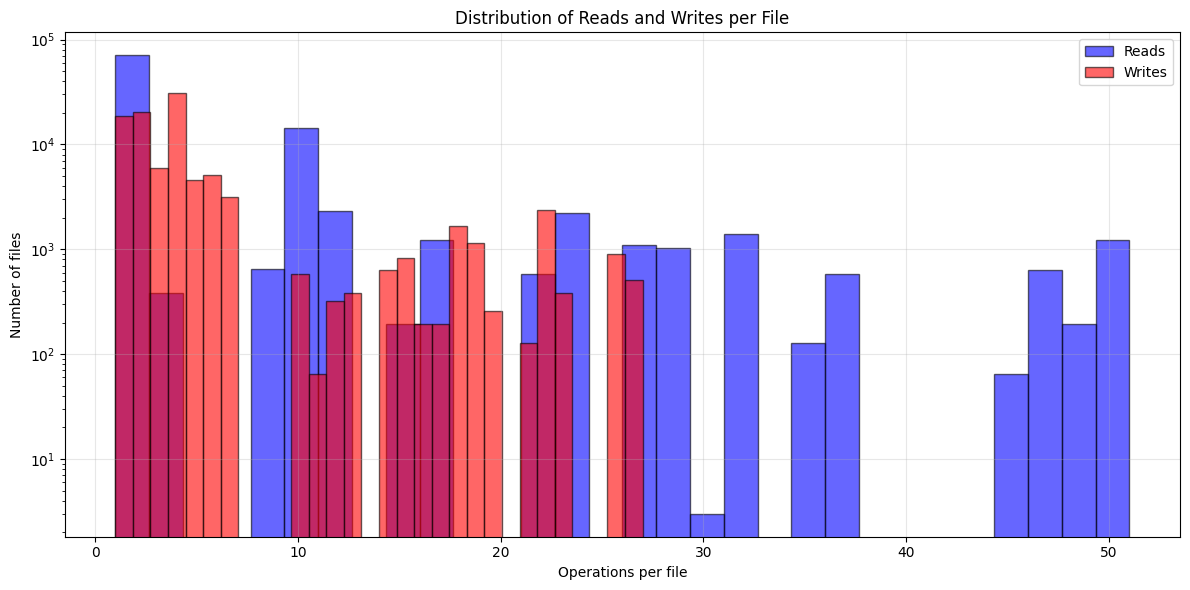

In [42]:
# Print summary statistics
print("Total number of read operations:", len(ares_read_df))
print("Total number of write operations:", len(ares_write_df))
print("\nNumber of unique files (reads):", ares_read_df['filename'].nunique())
print("Number of unique files (writes):", ares_write_df['filename'].nunique())

# Calculate operations per file
reads_per_file = ares_read_df['filename'].value_counts()
writes_per_file = ares_write_df['filename'].value_counts()

# Create the histogram
plt.figure(figsize=(12, 6))

# Create histograms with different alpha values and colors for overlap visibility
plt.hist(reads_per_file.values, bins=30, alpha=0.6, label='Reads', 
         edgecolor='black', color='blue')
plt.hist(writes_per_file.values, bins=30, alpha=0.6, label='Writes', 
         edgecolor='black', color='red')

# Set labels and title
plt.xlabel('Operations per file')
plt.ylabel('Number of files')
plt.title('Distribution of Reads and Writes per File')

# Use log scale for y-axis
plt.yscale('log')

# Add grid
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

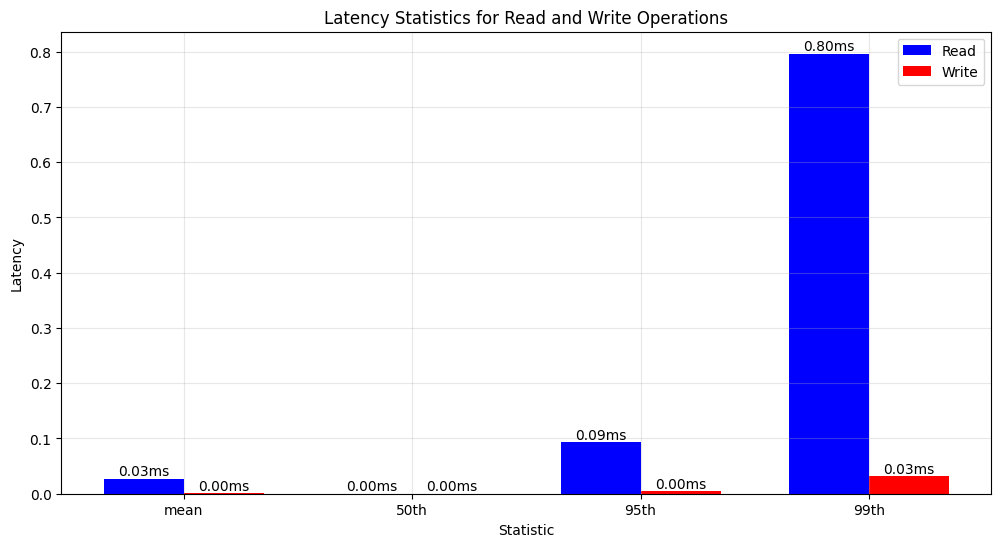


Read Statistics:
Mean: 0.02688703066009102
50th percentile: 0.0002910000000000412
95th percentile: 0.09282994999999993
99th percentile: 0.7962577500000009

Write Statistics:
Mean: 0.0014545428473259573
50th percentile: 0.0002249999999999197
95th percentile: 0.0048180000000001
99th percentile: 0.032069800000000086


In [43]:
# Calculate mean and percentiles separately for reads
ares_read_df_mean = ares_read_df['latency'].mean()
read_percentiles = ares_read_df['latency'].quantile([0.50, 0.95, 0.99])

# Calculate mean and percentiles separately for writes
ares_write_df_mean = ares_write_df['latency'].mean()
write_percentiles = ares_write_df['latency'].quantile([0.50, 0.95, 0.99])

# Create labels and positions for bars
labels = ['mean', '50th', '95th', '99th']
x = np.arange(len(labels))
width = 0.35

# Create the bar chart
plt.figure(figsize=(12, 6))
read_bars = plt.bar(x - width/2, [ares_read_df_mean] + list(read_percentiles), width, label='Read', color='blue')
write_bars = plt.bar(x + width/2, [ares_write_df_mean] + list(write_percentiles), width, label='Write', color='red')

# Customize the plot
plt.xlabel('Statistic')
plt.ylabel('Latency')
plt.title('Latency Statistics for Read and Write Operations')
plt.xticks(x, labels)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}ms',
                ha='center', va='bottom')

add_labels(read_bars)
add_labels(write_bars)

# Show the plot
plt.show()

# Print actual values
print("\nRead Statistics:")
print(f"Mean: {ares_read_df_mean}")
print(f"50th percentile: {read_percentiles[0.50]}")
print(f"95th percentile: {read_percentiles[0.95]}")
print(f"99th percentile: {read_percentiles[0.99]}")

print("\nWrite Statistics:")
print(f"Mean: {ares_write_df_mean}")
print(f"50th percentile: {write_percentiles[0.50]}")
print(f"95th percentile: {write_percentiles[0.95]}")
print(f"99th percentile: {write_percentiles[0.99]}")

### Eliminatig outliers in thesios_df
We remove 0B as they are not needed for analysis and 8MB as there are very few samples of this size. 
In ares, we have fixed req IO sizes but in thesios, they are of different combinations. So for each size, we set a threshold to pick upto 10% above and below sizes. 

In [44]:
# Define the exact sizes we want to keep (in bytes)
desired_sizes = {
    '512B': 512,
    '4KB': 4 * 1024,
    '64KB': 64 * 1024,
    '512KB': 512 * 1024,
    '1MB': 1024 * 1024,
}

In [45]:
# Create a function to analyze the distribution
def analyze_io_size_buckets(df, field):
    results = {}
    
    # Count exact matches
    for size_name in desired_sizes.keys():
        count = len(df[df[field] == size_name])
        results[f'{size_name}'] = count
    
    # Count "Others" (buckets not in desired_sizes)
    other_buckets = df[~df[field].isin(desired_sizes.keys())][field].value_counts()
    for bucket, count in other_buckets.items():
        results[f'Other: {bucket}'] = count
        
    return results


In [46]:
#DF for thesios data
# Create an empty mask to store our conditions
final_mask = pd.Series(False, index=thesios_df.index)

# For each desired size, create a mask for values within ±10%
for size_name, size_value in desired_sizes.items():
    lower_bound = size_value * 0.8  # 10% below
    upper_bound = size_value * 1.2  # 10% above
    
    size_mask = (thesios_df['request_io_size_bytes'] >= lower_bound) & \
                (thesios_df['request_io_size_bytes'] <= upper_bound)
    
    final_mask = final_mask | size_mask

# Apply the mask to filter the dataframe
filtered_thesios_df = thesios_df[final_mask].copy()


# Verify the filtering
print("Original number of entries:", len(thesios_df))
print("Filtered number of entries:", len(filtered_thesios_df))

Original number of entries: 90845430
Filtered number of entries: 24280617


In [47]:
def io_size_distribution(title, df, field, op_type = None):
    # Get the results
    if op_type!= None:
        df = df[(df['op_type'] == op_type)]
    results = analyze_io_size_buckets(df, field)
    
    # Print results in a readable format
    print(f"{title} I/O Size Distribution:")
    print("-" * 50)
    total_samples = len(df)

    for category, count in results.items():
        if total_samples != 0:
            percentage = (count / total_samples) * 100
            print(f"{category}: {count:,} samples ({percentage:.2f}%)")
    
    # Print total samples for verification
    print(f"\nTotal samples: {total_samples:,}")

io_size_distribution("(WRITES) Ares", ares_write_df, 'request_io_size_bucket', 'write')
io_size_distribution("(WRITES) Ares NVME ", ares_nvme_write_df, 'request_io_size_bucket', 'write')
io_size_distribution("(WRITES) Ares SSD", ares_ssd_write_df, 'request_io_size_bucket', 'write')
io_size_distribution("(WRITES) Ares HDD", ares_hdd_write_df, 'request_io_size_bucket', 'write')
io_size_distribution("(WRITES) Thesios", filtered_thesios_df, 'request_io_size_bucket', 'WRITE')


io_size_distribution("(READS) Ares", ares_read_df, 'request_io_size_bucket', 'read')
io_size_distribution("(READS) Ares NVME ", ares_nvme_read_df, 'request_io_size_bucket', 'read')
io_size_distribution("(READS) Ares SSD", ares_ssd_read_df, 'request_io_size_bucket', 'read')
io_size_distribution("(READS) Ares HDD", ares_hdd_read_df, 'request_io_size_bucket', 'read')
io_size_distribution("(READS) Thesios", filtered_thesios_df, 'request_io_size_bucket', 'READ')


(WRITES) Ares I/O Size Distribution:
--------------------------------------------------
512B: 68,608 samples (14.37%)
4KB: 114,174 samples (23.92%)
64KB: 105,536 samples (22.11%)
512KB: 75,265 samples (15.77%)
1MB: 113,728 samples (23.83%)

Total samples: 477,311
(WRITES) Ares NVME  I/O Size Distribution:
--------------------------------------------------
512B: 33,728 samples (18.27%)
4KB: 39,231 samples (21.25%)
64KB: 36,352 samples (19.69%)
512KB: 36,224 samples (19.63%)
1MB: 39,040 samples (21.15%)

Total samples: 184,575
(WRITES) Ares SSD I/O Size Distribution:
--------------------------------------------------
512B: 21,824 samples (11.91%)
4KB: 46,655 samples (25.47%)
64KB: 43,776 samples (23.90%)
512KB: 24,384 samples (13.31%)
1MB: 46,528 samples (25.40%)

Total samples: 183,167
(WRITES) Ares HDD I/O Size Distribution:
--------------------------------------------------
512B: 13,056 samples (11.92%)
4KB: 28,288 samples (25.82%)
64KB: 25,408 samples (23.19%)
512KB: 14,657 samples (

In [48]:
# Filter for write operations for each disk type
thesios_writes = filtered_thesios_df[(filtered_thesios_df['op_type'] == "WRITE")]
thesios_writes = thesios_writes[thesios_writes['request_io_size_bytes'] != 0]
thesios_writes = thesios_writes.rename(columns={'simulated_latency': 'latency'})

# Filter for write operations for each disk type
thesios_reads = filtered_thesios_df[(filtered_thesios_df['op_type'] == "READ")]
thesios_reads = thesios_reads[thesios_reads['request_io_size_bytes'] != 0]
thesios_reads = thesios_reads.rename(columns={'simulated_latency': 'latency'})

In [49]:
# Calculate statistics for both disk types
def get_stats(data):
    return {
        'Mean': data['latency'].mean(),
        '50p': data['latency'].quantile(0.50),
        '95p': data['latency'].quantile(0.95),
        '99p': data['latency'].quantile(0.99)
    }


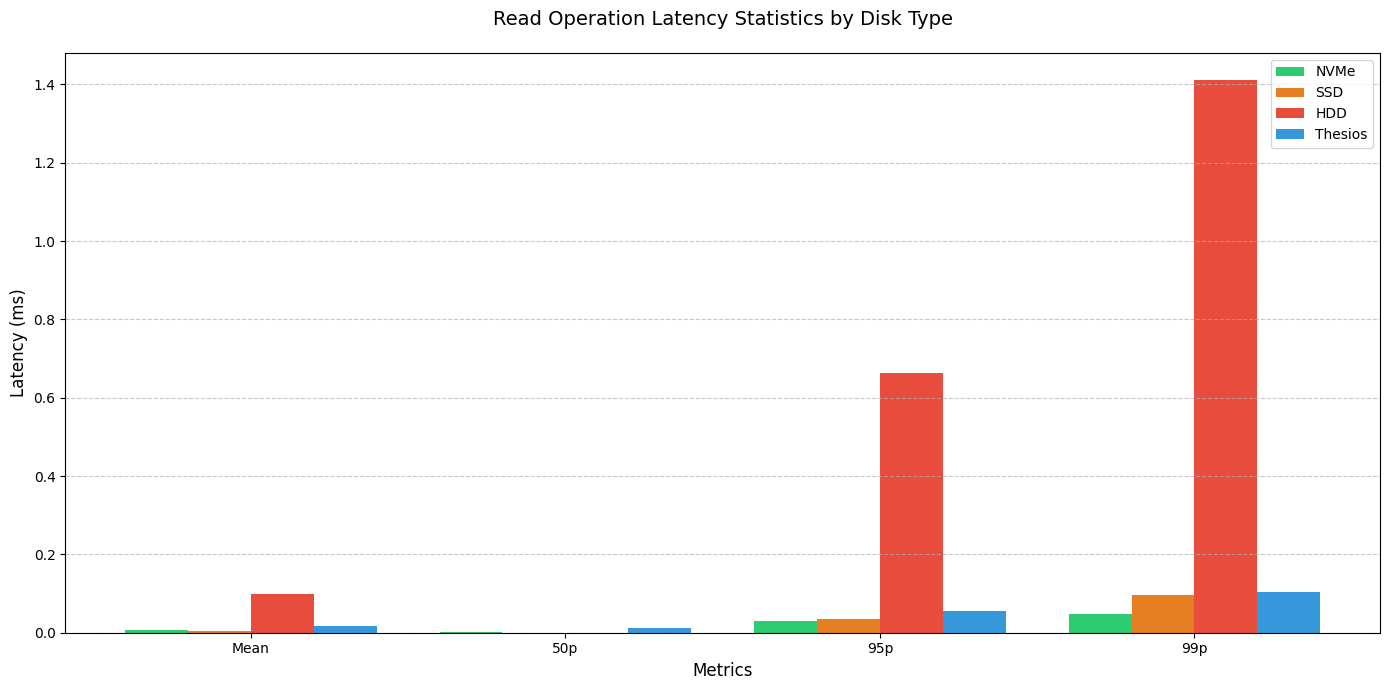

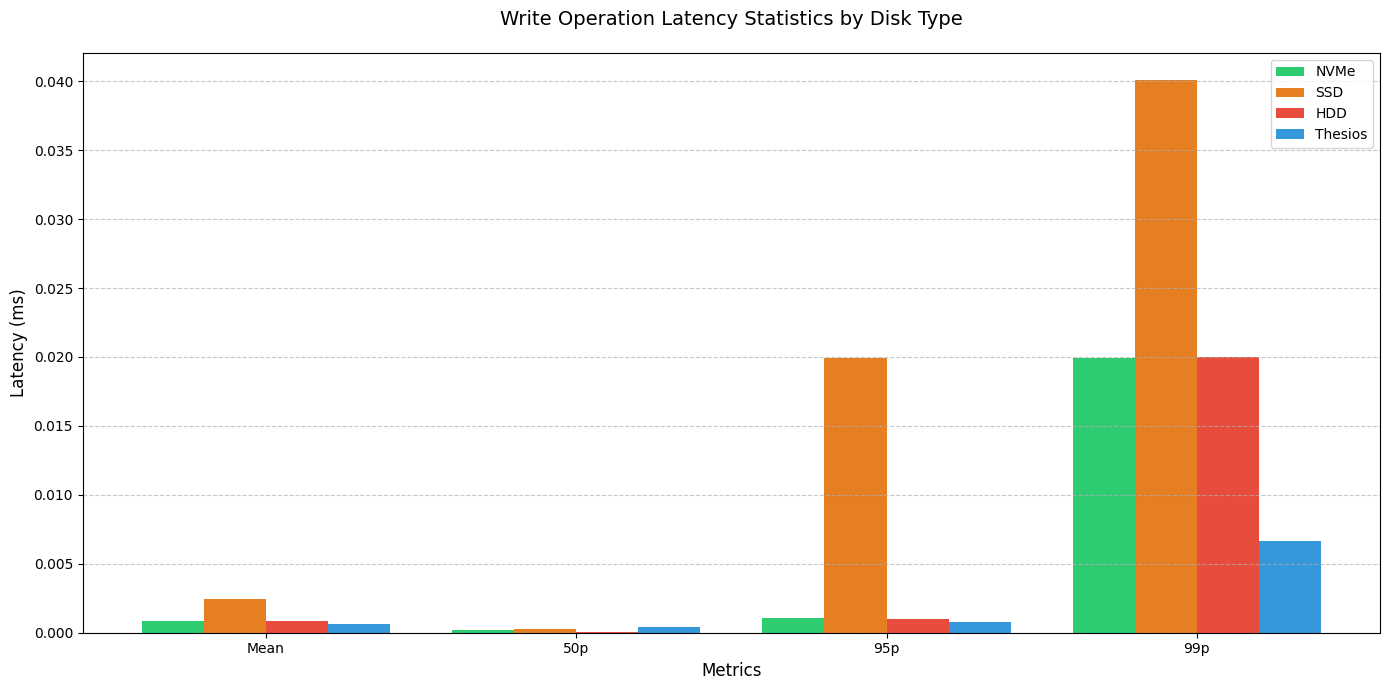

In [51]:
def op_latency_by_disk_stats(title, ares_nvme_df, ares_ssd_df, ares_hdd_df, thesios_op_df):
    ares_nvme_stats = get_stats(ares_nvme_df)
    ares_ssd_stats = get_stats(ares_ssd_df)
    ares_hdd_stats = get_stats(ares_hdd_df)
    thesios_stats = get_stats(thesios_op_df)
    plt.figure(figsize=(14, 7)) 
    
    metrics = list(ares_nvme_stats.keys())
    x = np.arange(len(metrics))
    width = 0.2 
    
    nvme_bars = plt.bar(x - 1.5*width, ares_nvme_stats.values(), width, label='NVMe', color='#2ecc71')
    ssd_bars = plt.bar(x - 0.5*width, ares_ssd_stats.values(), width, label='SSD', color='#e67e22')
    hdd_bars = plt.bar(x + 0.5*width, ares_hdd_stats.values(), width, label='HDD', color='#e74c3c')
    thesios_bars = plt.bar(x + 1.5*width, thesios_stats.values(), width, label='Thesios', color='#3498db')
    
    plt.title(title, pad=20, fontsize=14)
    plt.ylabel('Latency (ms)', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.xticks(x, metrics)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


op_latency_by_disk_stats('Read Operation Latency Statistics by Disk Type', ares_nvme_read_df, ares_ssd_read_df, ares_hdd_read_df, thesios_reads)
op_latency_by_disk_stats('Write Operation Latency Statistics by Disk Type', ares_nvme_write_df, ares_ssd_write_df, ares_hdd_write_df, thesios_writes)


In [52]:
ares_nvme_write_df.head()

,record_id,filename,disk_type,op_type,response_io,start_time,end_time,disk_time,latency,bandwidth,request_io_size_bucket
22914,2193437538285129969,/mnt/nvme/vpapudesibabu/iortests/test-0-512b-5...,nvme,write,512,1.828368,1.828695,0.000327,0.000327,0.0,512B
22915,5415467729000807455,/mnt/nvme/vpapudesibabu/iortests/test-0-512b-5...,nvme,write,512,1.829009,1.829065,0.000056,0.000056,0.0,512B
22916,5034030639390806591,/mnt/nvme/vpapudesibabu/iortests/test-0-512b-5...,nvme,write,512,1.844371,1.844381,0.000010,0.000010,0.0,512B
22917,9204399034123179237,/mnt/nvme/vpapudesibabu/iortests/test-0-512b-5...,nvme,write,512,1.836280,1.836290,0.000009,0.000010,0.0,512B
22918,8951562486958809413,/mnt/nvme/vpapudesibabu/iortests/test-0-512b-5...,nvme,write,512,1.828484,1.828495,0.000011,0.000011,0.0,512B


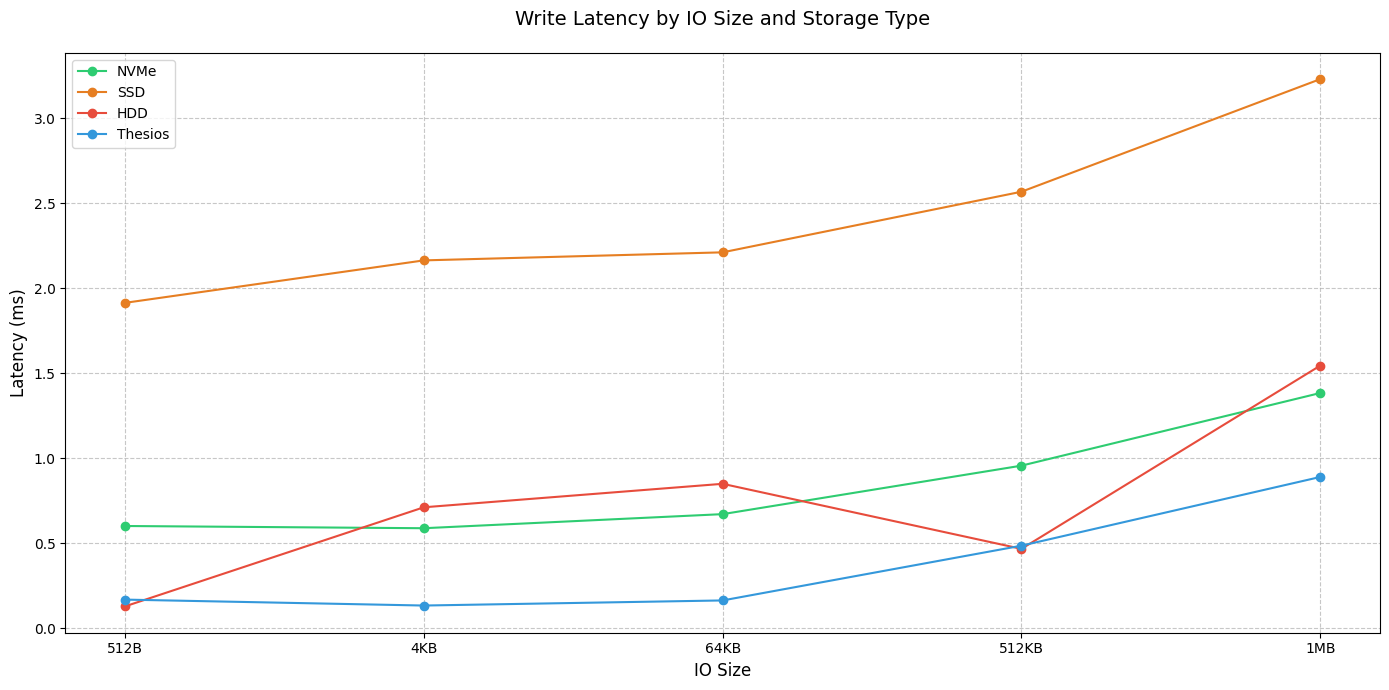

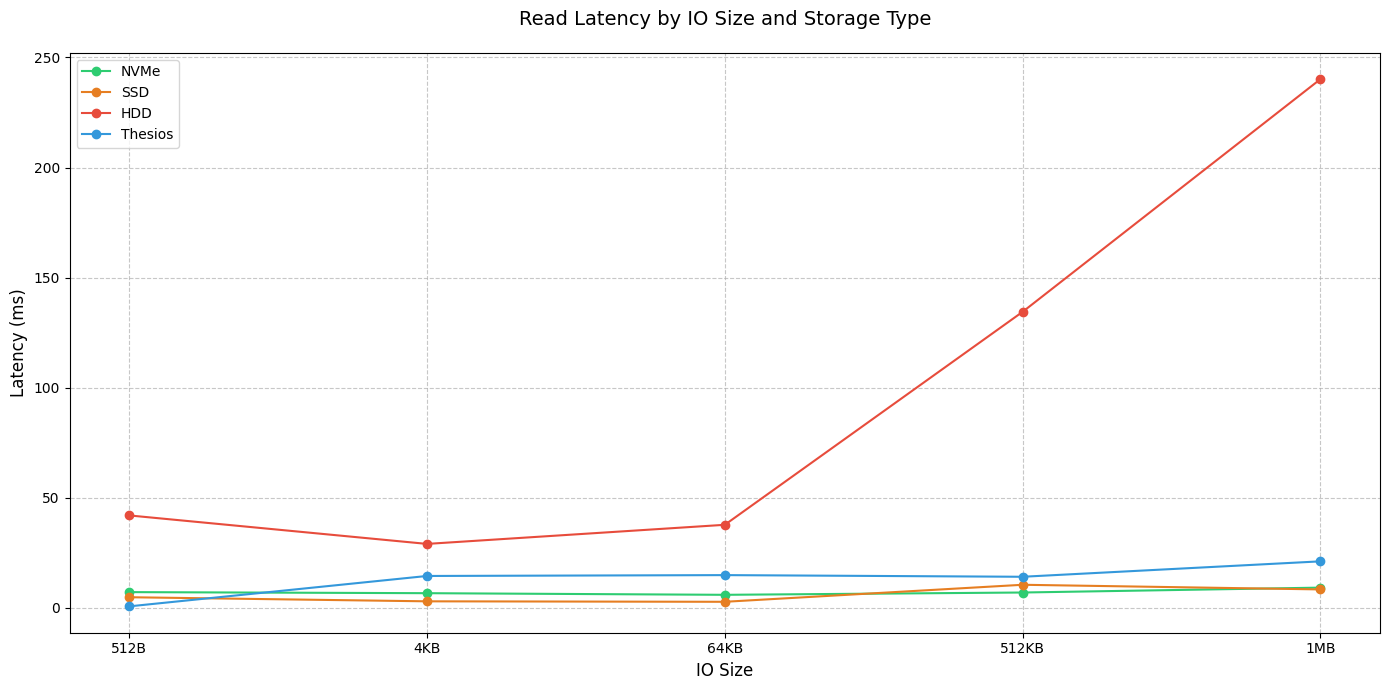

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latency_trend(title, storage_dfs):
    plt.figure(figsize=(14, 7))

    sizes = ['512B', '4KB', '64KB', '512KB', '1MB']
    x = np.arange(len(sizes))

    colors = ['#2ecc71', '#e67e22', '#e74c3c', '#3498db']
    labels = ['NVMe', 'SSD', 'HDD', 'Thesios']

    for i, (df, label, color) in enumerate(zip(storage_dfs, labels, colors)):
        latencies = [df[df['request_io_size_bucket'].str.contains(size, case=False, na=False)]['latency'].mean()*1000 for size in sizes]
        plt.plot(x, latencies, label=label, color=color, marker='o')

    plt.title(title, pad=20, fontsize=14)
    plt.ylabel('Latency (ms)', fontsize=12)
    plt.xlabel('IO Size', fontsize=12)
    plt.xticks(x, sizes)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_latency_trend('Write Latency by IO Size and Storage Type', 
                   [ares_nvme_write_df, ares_ssd_write_df, ares_hdd_write_df, thesios_writes])

plot_latency_trend('Read Latency by IO Size and Storage Type', 
                   [ares_nvme_read_df, ares_ssd_read_df, ares_hdd_read_df, thesios_reads])

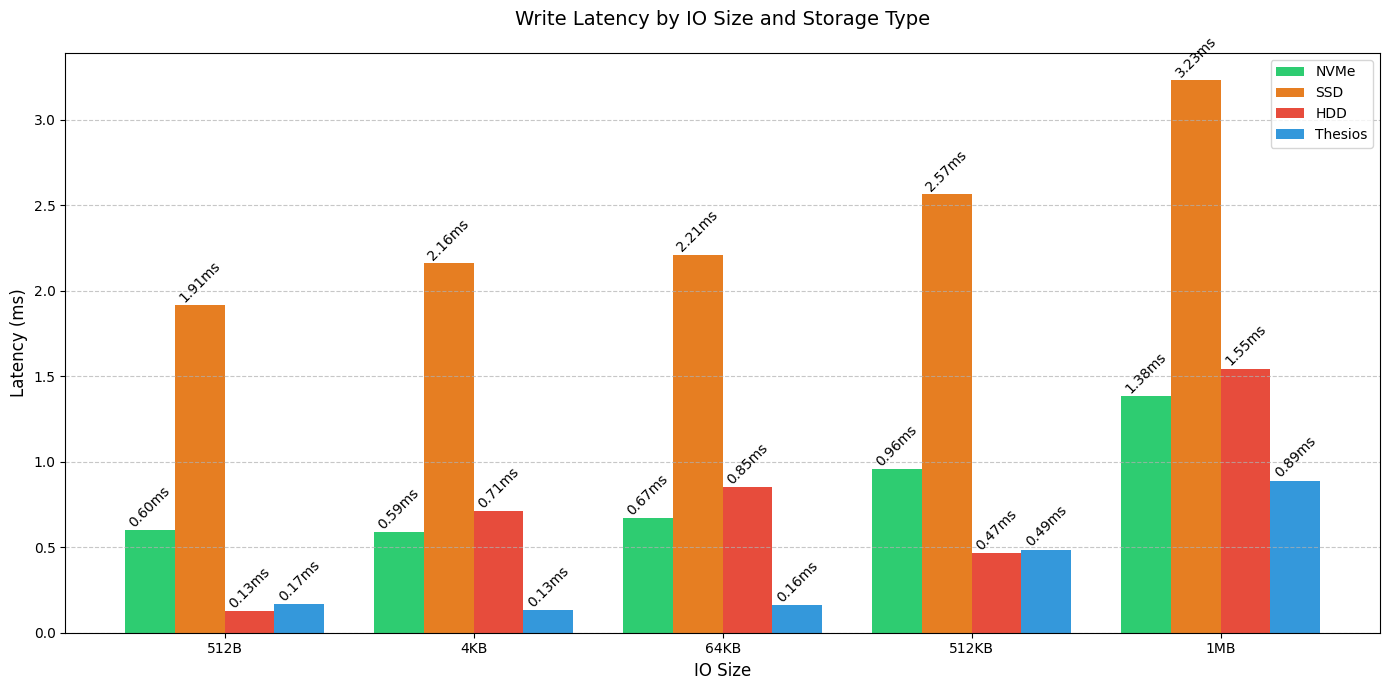

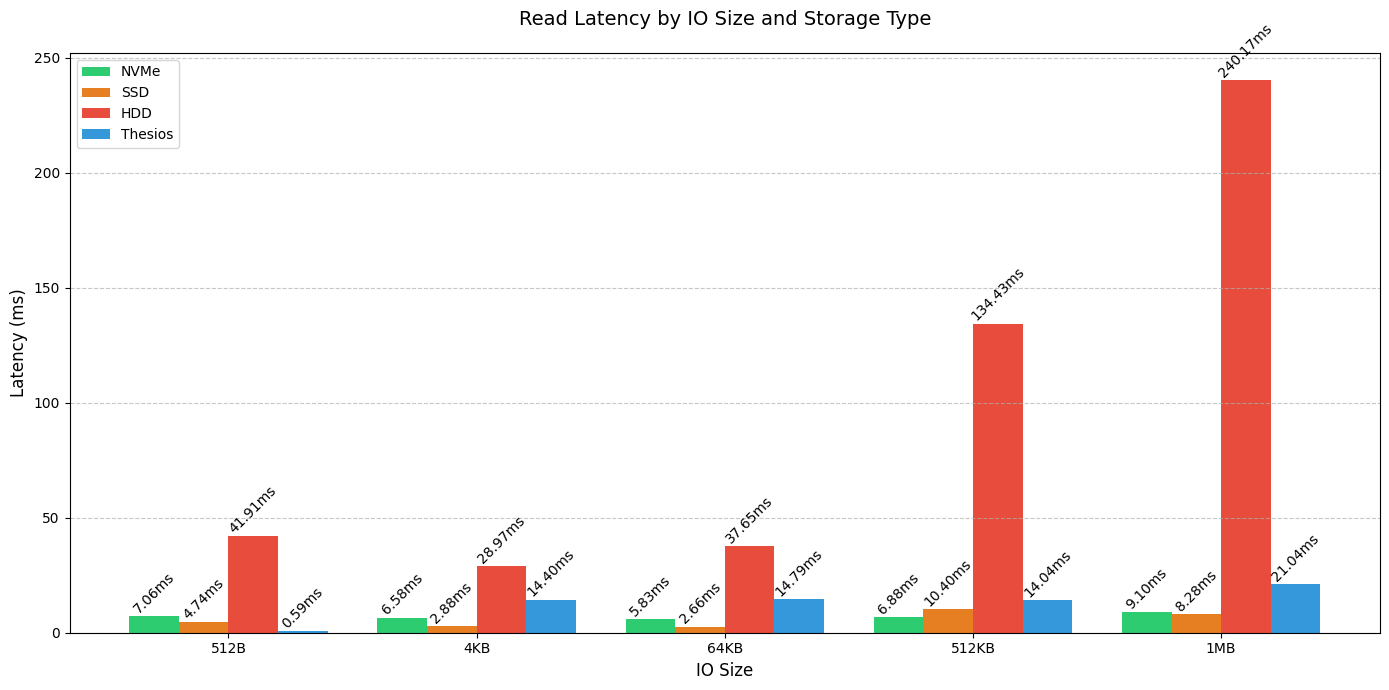

In [54]:
def get_size_latencies(df, bucket_field='request_io_size_bucket', latency_field='latency'):
    sizes = ['512B', '4KB', '64KB', '512KB', '1MB']
    
    results = {}
    for size in sizes:
        # Use str.contains for partial matching
        mask = df[bucket_field].str.contains(size, case=False, na=False)
        if mask.any():
            results[size] = df[mask][latency_field].mean()*1000
        else:
            results[size] = np.nan
            
    return results

def op_latency_by_size_stats(title, ares_nvme_df, ares_ssd_df, ares_hdd_df, thesios_op_df):
    nvme_latencies = get_size_latencies(ares_nvme_df, 'request_io_size_bucket')
    ssd_latencies = get_size_latencies(ares_ssd_df, 'request_io_size_bucket')
    hdd_latencies = get_size_latencies(ares_hdd_df, 'request_io_size_bucket')
    thesios_latencies = get_size_latencies(thesios_op_df, 'request_io_size_bucket')
    
    plt.figure(figsize=(14, 7))
    
    sizes = ['512B', '4KB', '64KB', '512KB', '1MB']
    x = np.arange(len(sizes))
    width = 0.2
    
    nvme_bars = plt.bar(x - 1.5*width, [nvme_latencies.get(size, 0) for size in sizes], 
                        width, label='NVMe', color='#2ecc71')
    ssd_bars = plt.bar(x - 0.5*width, [ssd_latencies.get(size, 0) for size in sizes], 
                       width, label='SSD', color='#e67e22')
    hdd_bars = plt.bar(x + 0.5*width, [hdd_latencies.get(size, 0) for size in sizes], 
                       width, label='HDD', color='#e74c3c')
    thesios_bars = plt.bar(x + 1.5*width, [thesios_latencies.get(size, 0) for size in sizes], 
                           width, label='Thesios', color='#3498db')
    
    plt.title(title, pad=20, fontsize=14)
    plt.ylabel('Latency (ms)', fontsize=12)
    plt.xlabel('IO Size', fontsize=12)
    plt.xticks(x, sizes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add label if bar has value
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}ms',
                        ha='center', va='bottom', rotation=45)
    
    add_labels(nvme_bars)
    add_labels(ssd_bars)
    add_labels(hdd_bars)
    add_labels(thesios_bars)
    
    plt.tight_layout()
    plt.show()

op_latency_by_size_stats('Write Latency by IO Size and Storage Type', ares_nvme_write_df, ares_ssd_write_df, ares_hdd_write_df, thesios_writes)
op_latency_by_size_stats('Read Latency by IO Size and Storage Type', ares_nvme_read_df, ares_ssd_read_df, ares_hdd_read_df, thesios_reads)

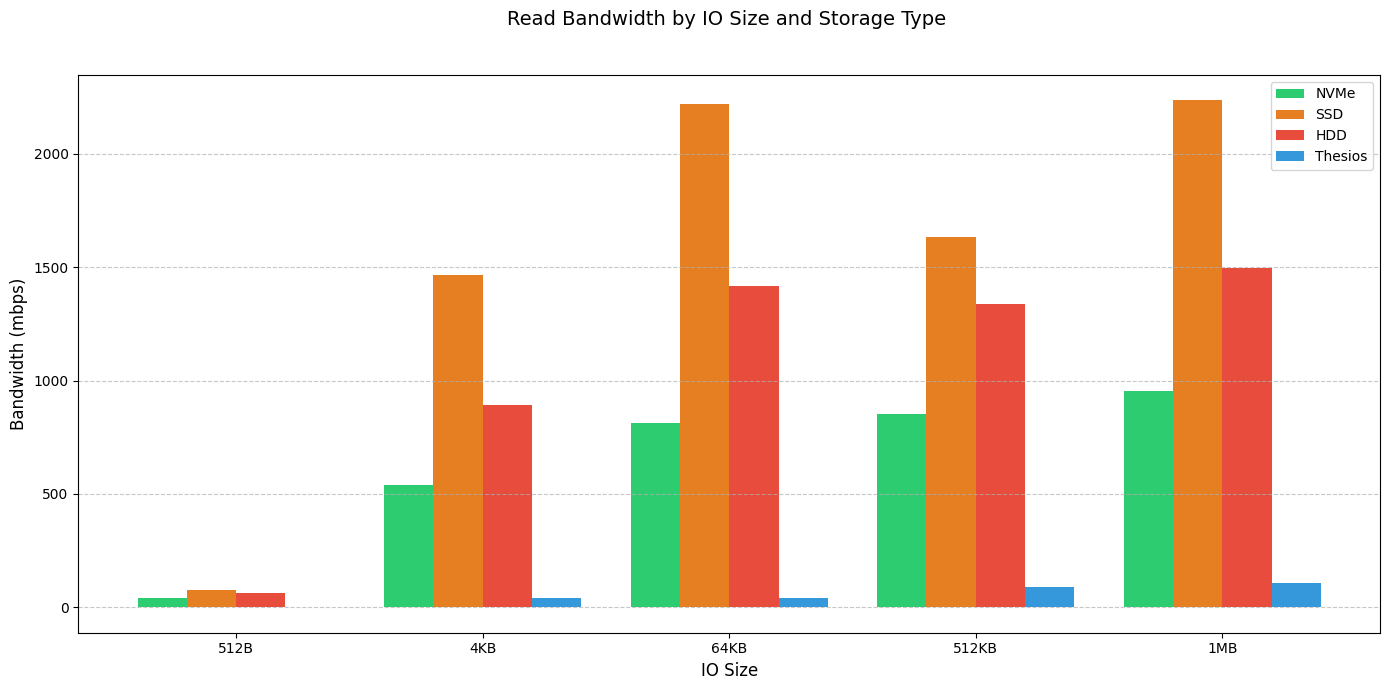

In [55]:
def op_bandwidth_by_size_stats(title, ares_nvme_df, ares_ssd_df, ares_hdd_df, thesios_op_df):
    nvme_bandwidth = get_size_bandwidth(ares_nvme_df, 'request_io_size_bucket')
    ssd_bandwidth = get_size_bandwidth(ares_ssd_df, 'request_io_size_bucket')
    hdd_bandwidth = get_size_bandwidth(ares_hdd_df, 'request_io_size_bucket')
    thesios_bandwidth = get_size_bandwidth(thesios_op_df, 'request_io_size_bucket')
    
    plt.figure(figsize=(14, 7))
    
    sizes = ['512B', '4KB', '64KB', '512KB', '1MB']
    x = np.arange(len(sizes))
    width = 0.2
    
    nvme_bars = plt.bar(x - 1.5*width, [nvme_bandwidth.get(size, 0) for size in sizes], 
                        width, label='NVMe', color='#2ecc71')
    ssd_bars = plt.bar(x - 0.5*width, [ssd_bandwidth.get(size, 0) for size in sizes], 
                       width, label='SSD', color='#e67e22')
    hdd_bars = plt.bar(x + 0.5*width, [hdd_bandwidth.get(size, 0) for size in sizes], 
                       width, label='HDD', color='#e74c3c')
    thesios_bars = plt.bar(x + 1.5*width, [thesios_bandwidth.get(size, 0) for size in sizes], 
                           width, label='Thesios', color='#3498db')
    
    plt.title(title, pad=20, fontsize=14)
    plt.ylabel('Bandwidth (mbps)', fontsize=12)
    plt.xlabel('IO Size', fontsize=12)
    plt.xticks(x, sizes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
op_bandwidth_by_size_stats('Read Bandwidth by IO Size and Storage Type \n', 
                          ares_nvme_read_df, ares_ssd_read_df, ares_hdd_read_df, thesios_reads)

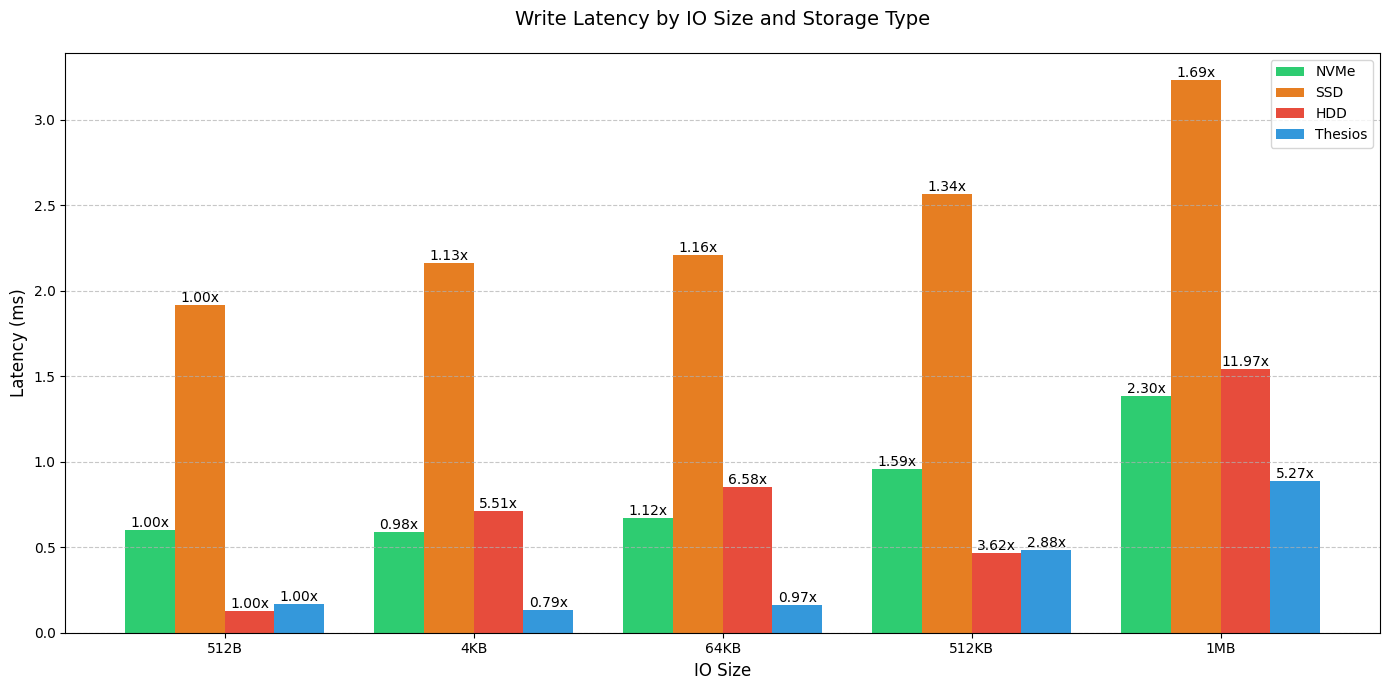

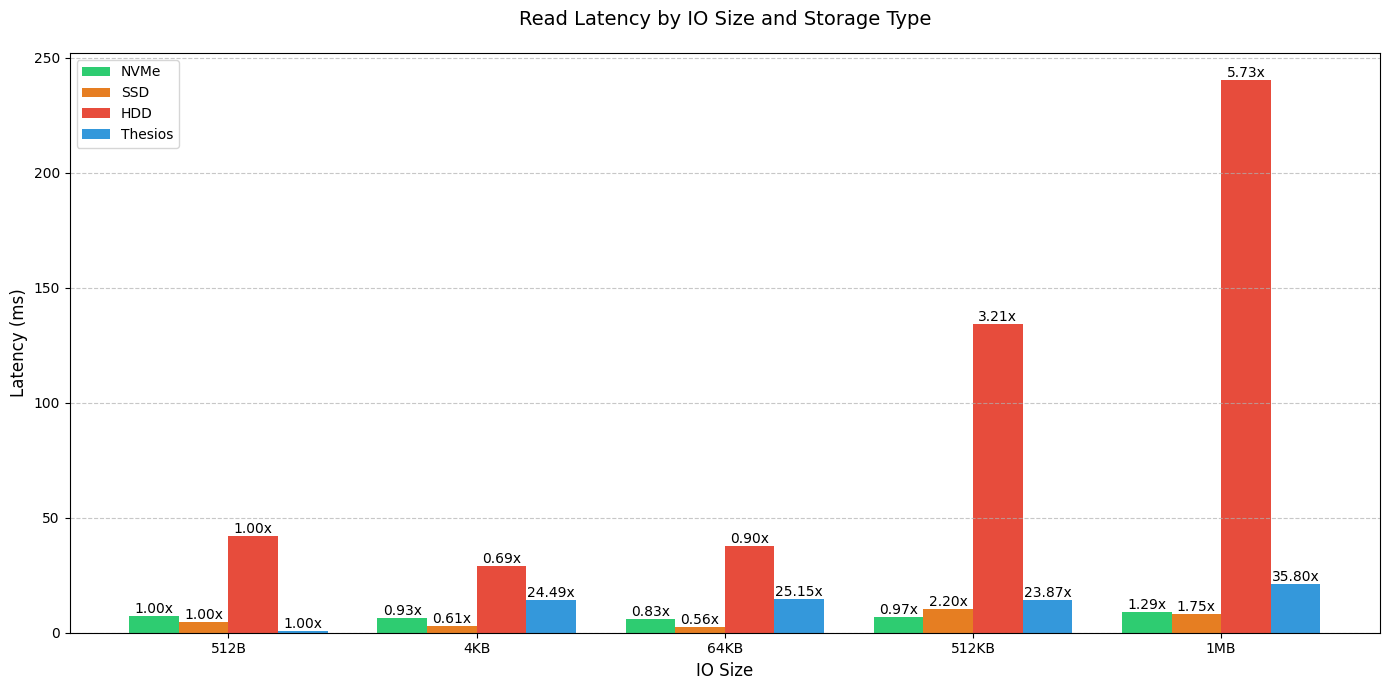

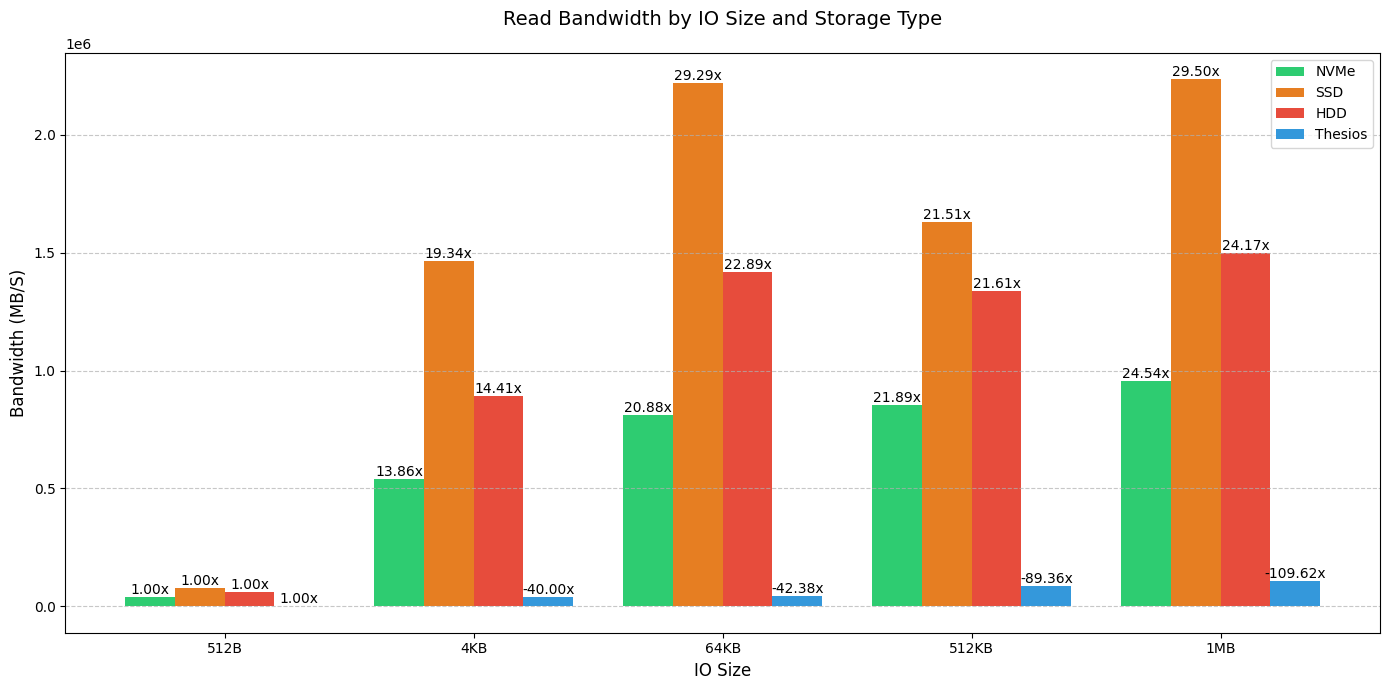

In [56]:
plot_trend('Write Latency by IO Size and Storage Type', 
                   [ares_nvme_write_df, ares_ssd_write_df, ares_hdd_write_df, thesios_writes], 'latency', 'Latency (ms)')
plot_trend('Read Latency by IO Size and Storage Type', 
                   [ares_nvme_read_df, ares_ssd_read_df, ares_hdd_read_df, thesios_reads], 'latency', 'Latency (ms)')
plot_trend('Read Bandwidth by IO Size and Storage Type', 
                   [ares_nvme_read_df, ares_ssd_read_df, ares_hdd_read_df, thesios_reads], 'bandwidth', 'Bandwidth (MB/S)')
